In [1]:
from utils.analysis.tools import simDir, springPhaseDiagram
from pathlib import Path
from utils.file_operations import input_parse
from tqdm import tqdm
import multiprocessing as mp 
from pathlib import Path
from utils import plot
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib as mpl
from utils.plot import _FIGURE_DIR, get_size_inches

root = Path("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/04_CoupledFlow/")

In [2]:
no_condensate = simDir("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/04_CoupledFlow/20240118_RNAOnly/M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_0.1_c1_3.53_sw_1.0_sr_2.5_cn_5.5_l_6_M3_1.0_kt_0.0_rl_9.0_wd_0.0")
no_condensate.run()
no_condensate.rna()
no_condensate_rna = no_condensate.rna_amount[-1]

In [3]:
class springPhaseDiagram:
    def __init__(self,
                 directory: str,
                 sweep_file: str = "sweep_parameters.txt"):
        self.sweep_directory = Path(directory)
        self.sweep_file = self.sweep_directory / sweep_file
        self.sweep_parameters = [line.split(",")[0] for line in self.sweep_file.read_text().splitlines()]

    def extract_data(self,frame):
        simdir_paths = [file.parent for file in self.sweep_directory.glob("./*/input_params.txt")]
        processes = mp.Pool(8-1)
        self.results = processes.map(self.worker,[(path,frame) for path in simdir_paths])
        self.df = pd.DataFrame(self.results)
        if 'rest_length' in self.df.columns:
            self.df.loc[:, "rest_length"] = self.df["rest_length"].apply(lambda x: eval(x)[0]).astype(np.float64)
        self.df.loc[:, "k_tilde"] = self.df["k_tilde"].astype(np.float64)
    
    def worker(self,worker_input):
        simdir_path, frame = worker_input
        sim = simDir(simdir_path)
        param_values = sim.params
        relevant_params = {parameter: str(param_values[parameter]) for parameter in self.sweep_parameters}
        sim.run()
        sim.rna()
        sim.condensate()
        return relevant_params | {"rna_amount": sim.rna_amount.flatten()[frame],
                                "condensate_com": sim.com[frame,0],
                                "aspect_ratio": sim.aspect_ratio[frame],
                                "mask": sim.xy[sim.mask[frame,:],:],
                                "concentration": sim.concentration_profile[0][frame,:][sim.mask[frame,:]]}

    def extract_enhancer_loci(self,frame):
        simdir_paths = [file.parent for file in self.sweep_directory.glob("./*/input_params.txt")]
        processes = mp.Pool(8-1)
        self.enhancer_loci = processes.map(self.enhancer_worker,[(path,frame) for path in simdir_paths])

    def enhancer_worker(self,worker_input):
        simdir_path, frame = worker_input
        simdir_path = Path(simdir_path)
        sim = simDir(simdir_path.as_posix())
        param_values = sim.params
        relevant_params = {parameter: str(param_values[parameter]) for parameter in self.sweep_parameters}
        df = pd.read_csv(simdir_path/"stats.txt",sep=r"\t")
        return relevant_params | {"enhancer_locus": df["well_center_x"].iloc[frame]}

In [4]:
spd = springPhaseDiagram(root/"20240122_PhaseDiagramFixedAccurateMobility")
# spd.extract_data(299)
# spd.df.to_pickle("20240122_PhaseDiagramFixedAccurateMobility.pkl")
spd.df = pd.read_pickle("20240122_PhaseDiagramFixedAccurateMobility.pkl")

In [9]:
spd.extract_enhancer_loci(-1)

In [43]:
spd.df

,rest_length,k_tilde,rna_amount,condensate_com,aspect_ratio,mask,concentration
0,9.5,1.0,13.906674,9.418056,1.022767,"[[6.8163426718229845, 0.27935955857859646], [6...","[4.495123, 4.0583377, 4.1514864, 4.2096534, 4...."
1,0.0,0.01,16.941945,0.013132,1.006734,"[[-1.246760428390709, 2.2598868240811765], [2....","[4.57357, 4.407653, 4.4232473, 4.5928354, 4.56..."
2,0.0,0.18,16.941969,-0.000386,1.001588,"[[-1.246760428390709, 2.2598868240811765], [2....","[4.5747075, 4.4040236, 4.4197593, 4.594982, 4...."
3,0.0,0.032,16.941968,0.002804,1.001471,"[[-1.246760428390709, 2.2598868240811765], [2....","[4.574485, 4.4048176, 4.4205203, 4.594567, 4.5..."
4,0.0,0.056,16.941969,0.000797,1.001593,"[[-1.246760428390709, 2.2598868240811765], [2....","[4.5746474, 4.404259, 4.4199843, 4.5948715, 4...."
...,...,...,...,...,...,...,...
184,9.5,0.32,13.907388,9.394990,1.008358,"[[6.8163426718229845, 0.27935955857859646], [6...","[4.505121, 4.085728, 4.021182, 4.1772547, 4.23..."
185,9.5,0.18,13.908326,9.355443,1.021993,"[[6.8163426718229845, 0.27935955857859646], [6...","[4.516751, 4.119053, 4.054875, 4.2079983, 4.26..."
186,9.5,0.56,13.906930,9.407978,1.022686,"[[6.8163426718229845, 0.27935955857859646], [6...","[4.498818, 4.06832, 4.003784, 4.1609306, 4.218..."
187,10.0,0.56,13.897975,9.940790,1.021687,"[[6.8163426718229845, 0.27935955857859646], [6...","[4.219211, 4.017024, 4.0741196, 4.467789, 4.16..."


In [10]:
df = pd.DataFrame(spd.enhancer_loci)
spd.df["enhancer_loci"] = df[df.columns[-1]]

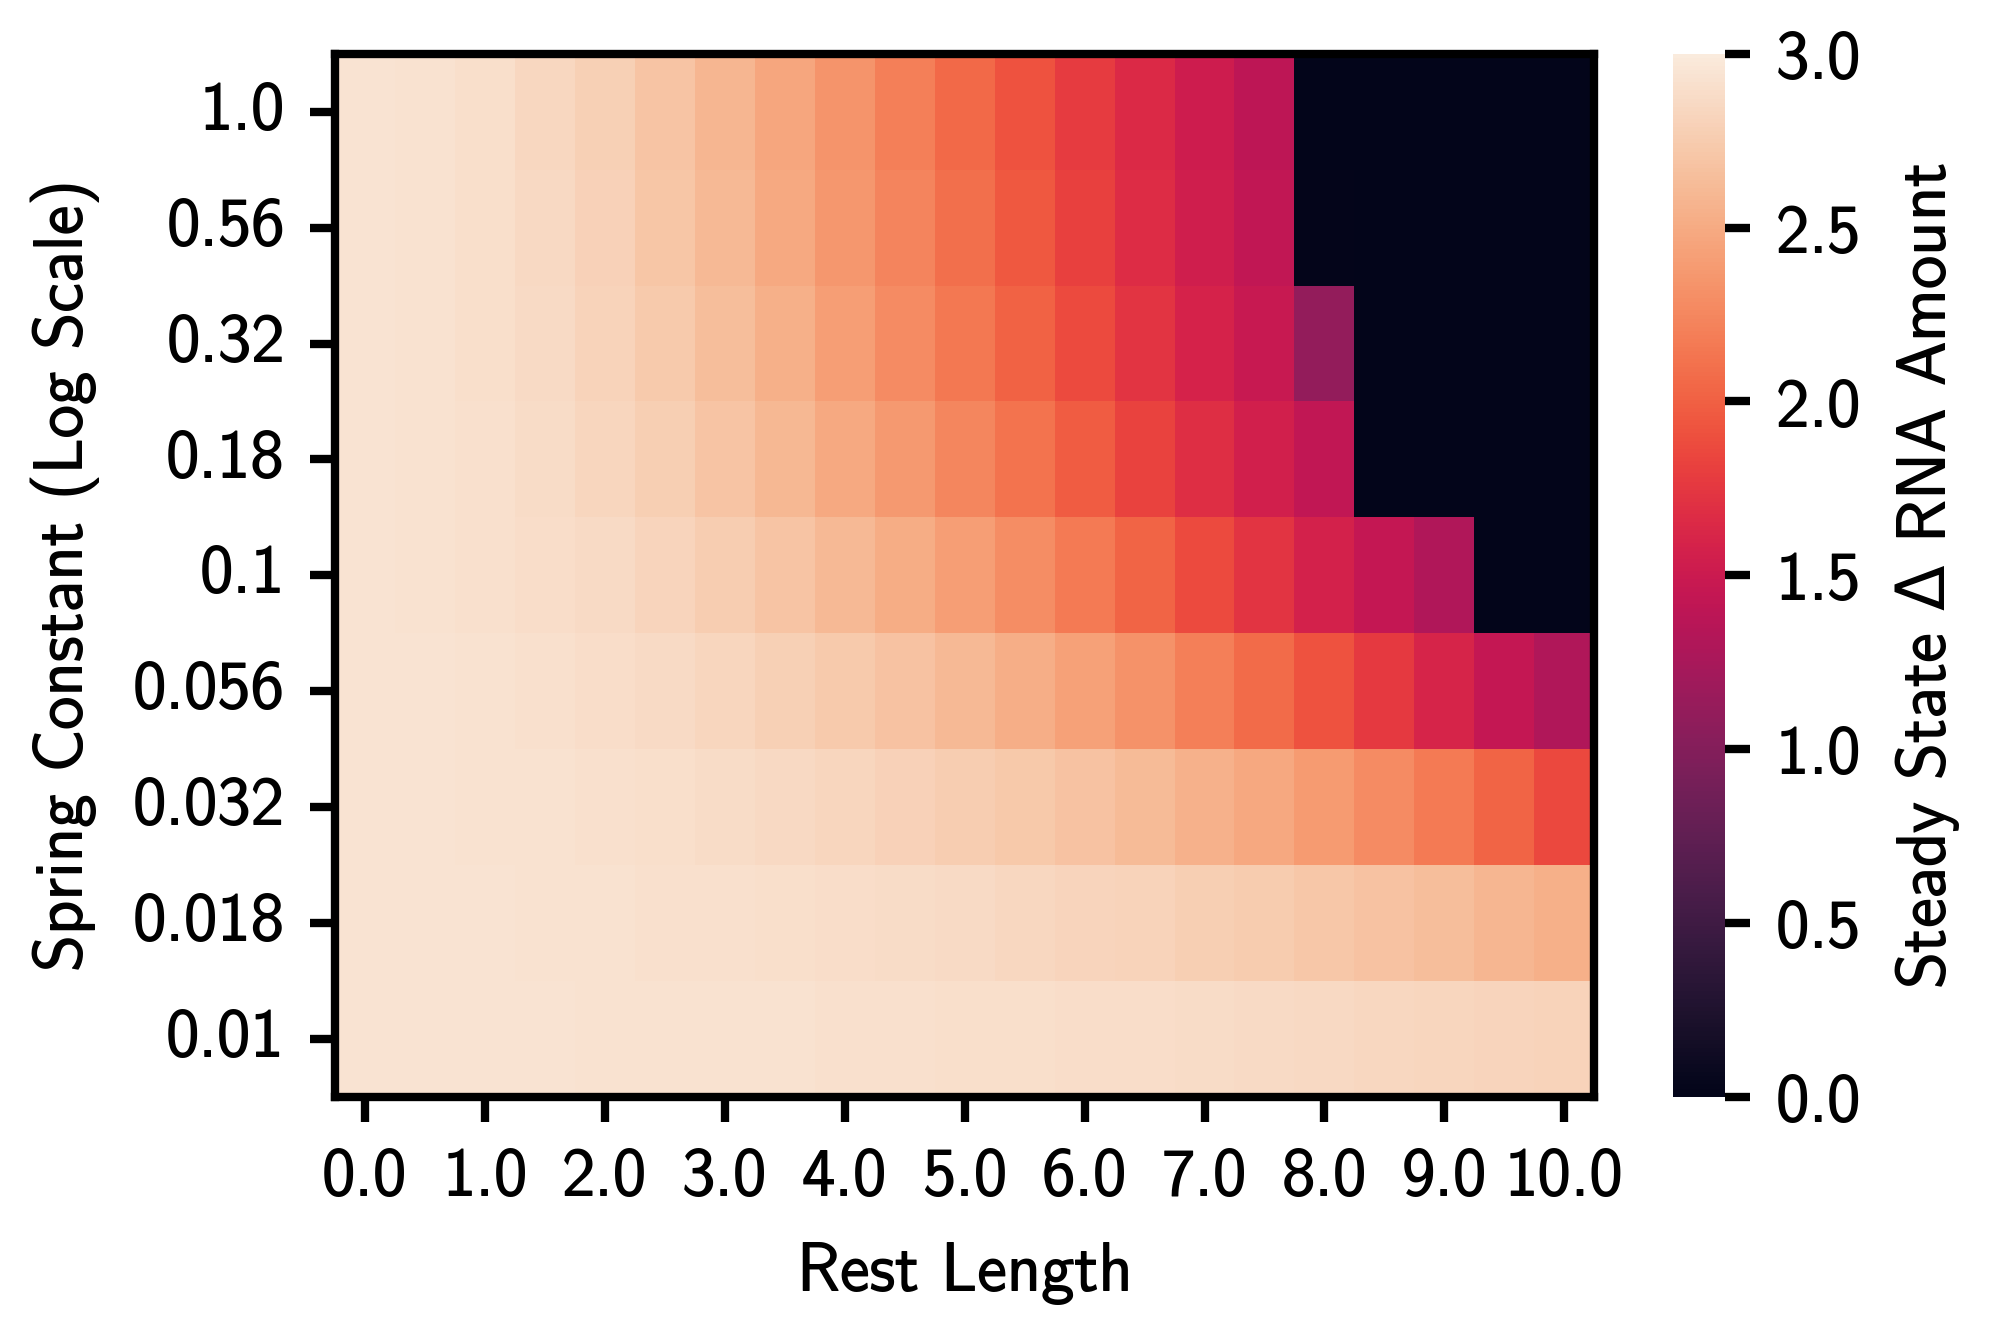

In [22]:
variable="rna_amount"
xlabel="Rest Length"
ylabel="Spring Constant (Log Scale)"
cbarlabel='Steady State $\Delta$ RNA Amount'

fig, ax = plt.subplots()
pivot = spd.df.pivot(index="k_tilde",columns="rest_length",values=variable)
sns.heatmap(pivot-no_condensate_rna, ax = ax,
            cbar_kws={'label': cbarlabel},
            vmin=0,vmax=3)
ax.invert_yaxis()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
for spine in ax.spines:
    ax.spines[spine].set_visible(True)

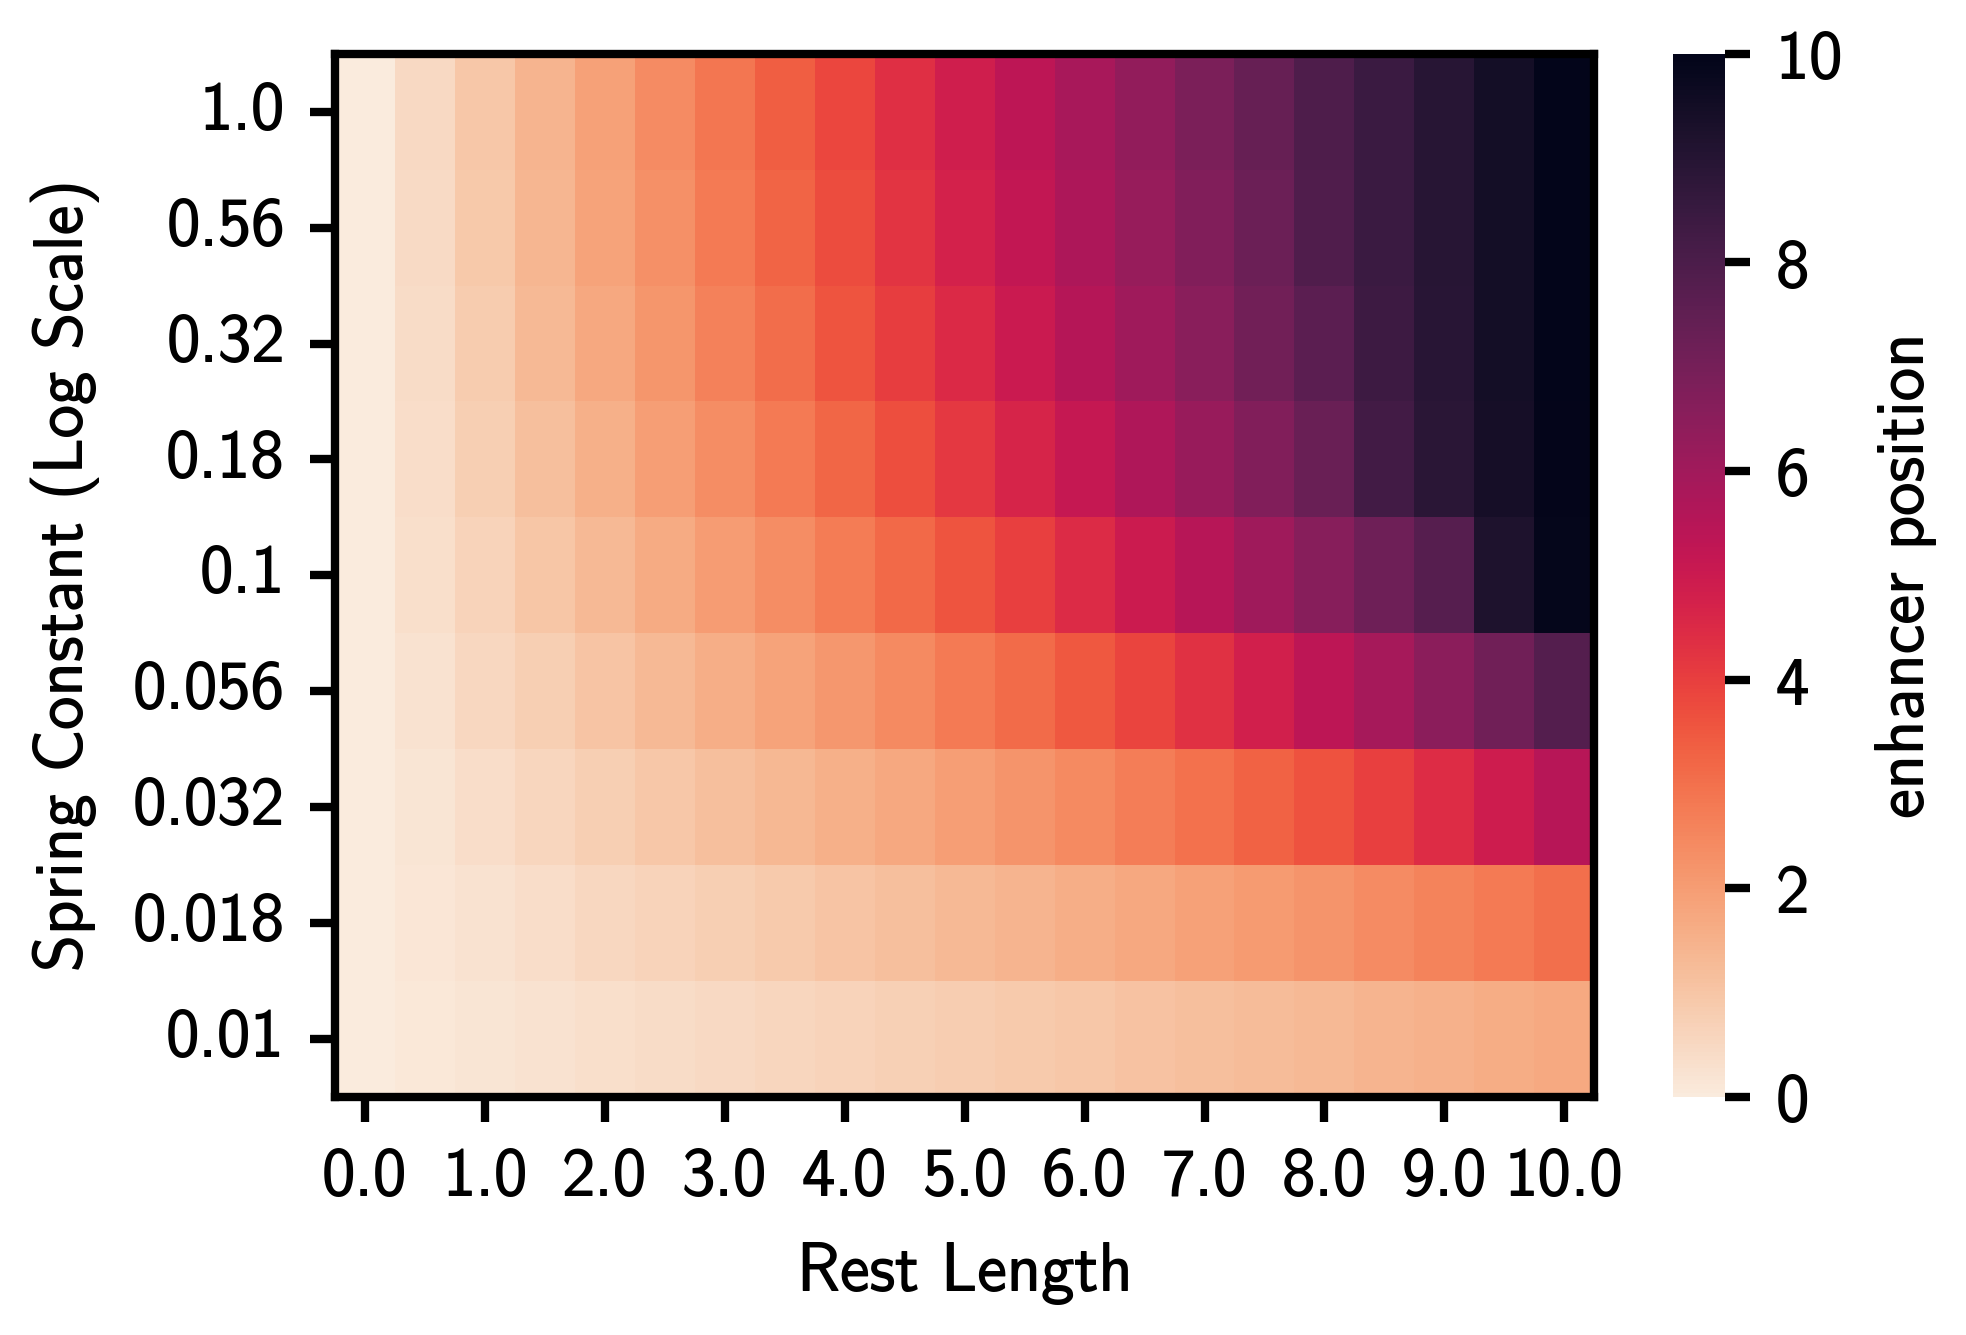

In [9]:
variable="enhancer_loci"
xlabel="Rest Length"
ylabel="Spring Constant (Log Scale)"
cbarlabel='enhancer position'

fig, ax = plt.subplots()
pivot = spd.df.pivot(index="k_tilde",columns="rest_length",values=variable)
sns.heatmap(pivot, ax = ax,
            cbar_kws={'label': cbarlabel},
            cmap="rocket_r",
            vmin=0,vmax=10)
ax.invert_yaxis()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
for spine in ax.spines:
    ax.spines[spine].set_visible(True)

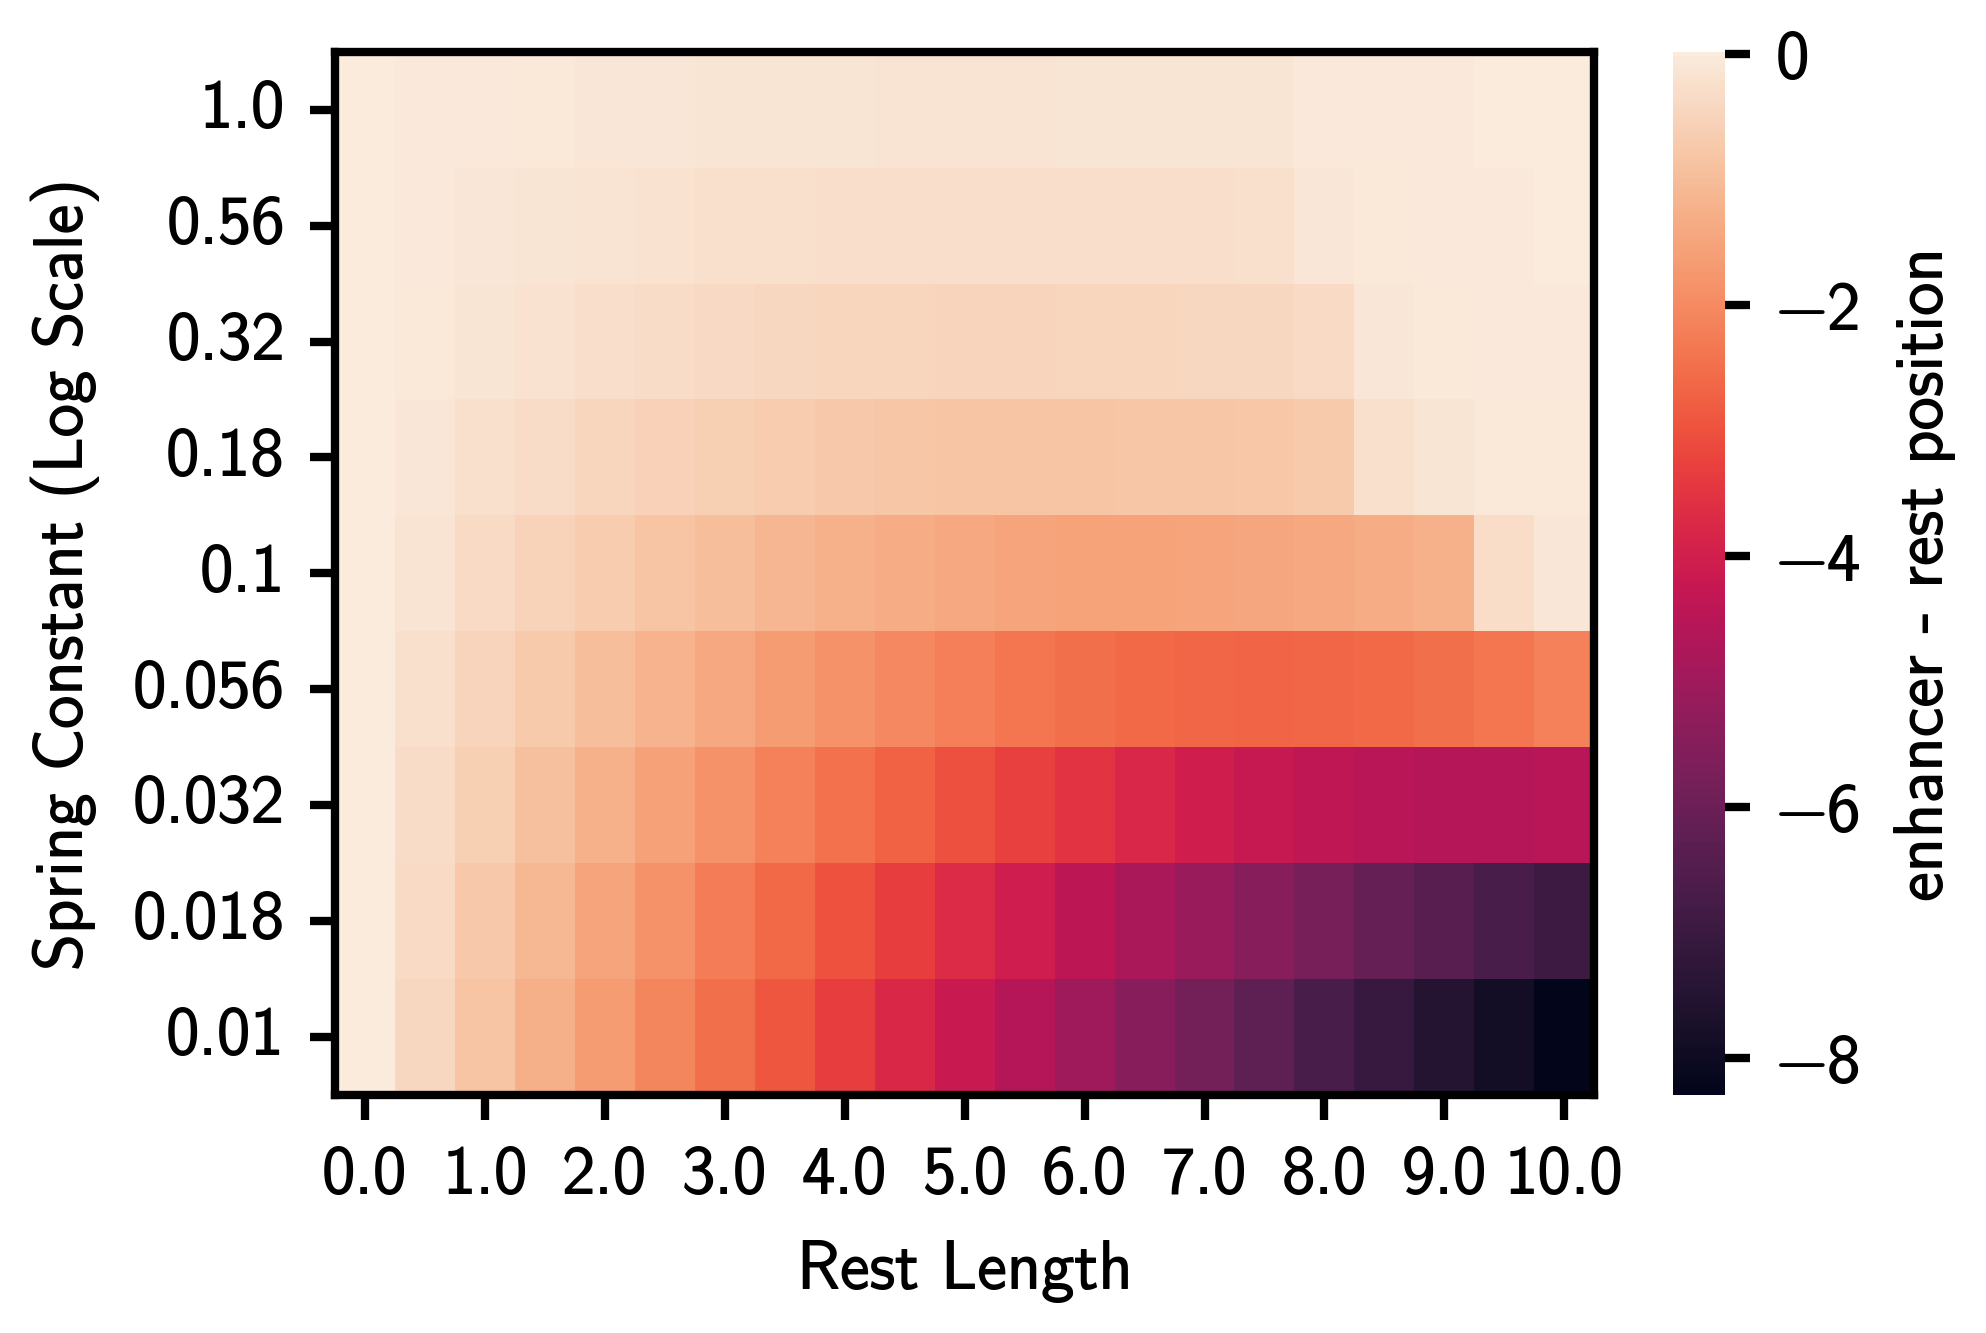

In [10]:
variable="enhancer_loci"
xlabel="Rest Length"
ylabel="Spring Constant (Log Scale)"
cbarlabel='enhancer - rest position'

fig, ax = plt.subplots()
pivot = spd.df.pivot(index="k_tilde",columns="rest_length",values=variable)-spd.df.pivot(index="k_tilde",columns="rest_length",values="rest_length").astype(np.float64)
sns.heatmap(pivot, ax = ax,
            cbar_kws={'label': cbarlabel})
ax.invert_yaxis()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
for spine in ax.spines:
    ax.spines[spine].set_visible(True)

In [4]:
def generate_linlog_sequence(min_value, max_value):
    if min_value <= 0 or max_value <= 0:
        raise ValueError("min_value and max_value must be positive")

    sequence = []

    # Start from the smallest power of 10 less than or equal to min_value
    min_power = int(np.floor(np.log10(min_value)))
    max_power = int(np.ceil(np.log10(max_value)))

    for power in range(min_power, max_power + 1):
        # For each power of 10, generate linear sequence
        start = max(10 ** power, min_value)
        end = min(10 ** (power + 1) - 1, max_value)
        sequence.extend(np.arange(start, end + 1, 10 ** power))

    return np.array(sequence)

[Text(0, 0.5, '$10^{-2}$'),
 Text(0, 4.5, '$10^{-1}$'),
 Text(0, 8.5, '$10^{0}$')]

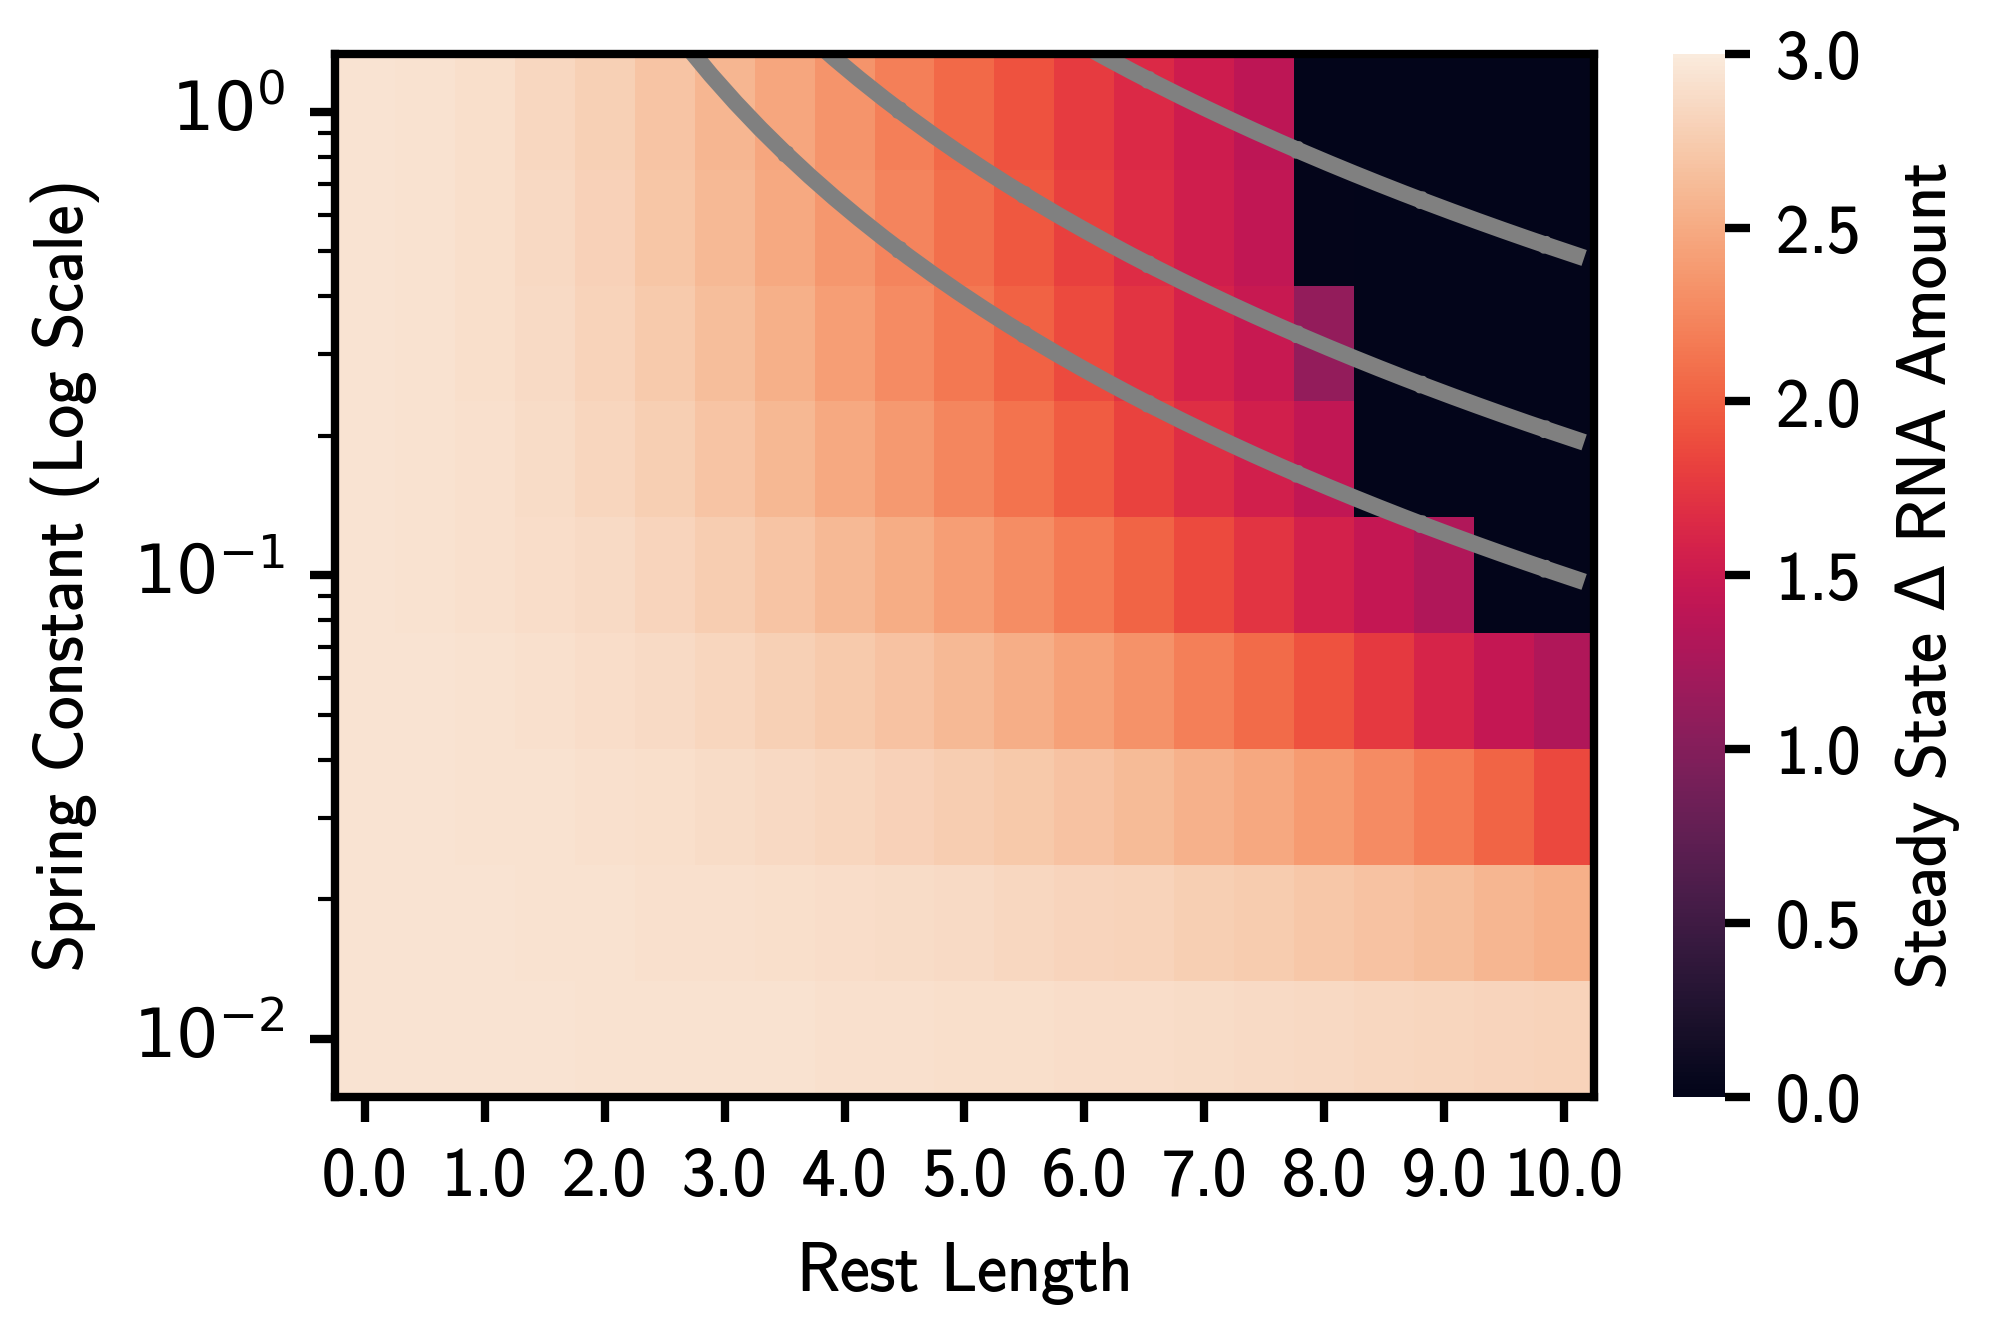

In [12]:
variable="rna_amount"
xlabel="Rest Length"
ylabel="Spring Constant (Log Scale)"
cbarlabel='Steady State $\Delta$ RNA Amount'

fig, ax = plt.subplots()
pivot = spd.df.pivot(index="k_tilde",columns="rest_length",values=variable)
g = sns.heatmap(pivot-no_condensate_rna, ax = ax,
            cbar_kws={'label': cbarlabel},
            vmin=0,vmax=3)
ax.invert_yaxis()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
for spine in ax.spines:
    ax.spines[spine].set_visible(True)
    
    
for c in [10, 20, 50]:
    line_x = np.linspace(0,10.1)
    line_y = c/line_x**2

    x_min, x_max = pivot.columns.min(), pivot.columns.max()
    mapped_x = (line_x - x_min) / (x_max - x_min) * (len(pivot.columns) - 1)+0.5

    # Map y coordinates (logarithmic scale)
    y_min, y_max = np.log(pivot.index.min()), np.log(pivot.index.max())
    mapped_y = (np.log(line_y) - y_min) / (y_max - y_min) * (len(pivot.index) - 1)+0.5

    line, = ax.plot(mapped_x,mapped_y,color="grey")
    plot.add_arrow(line,direction='left')

def map_y(y):
    return (np.log(y) - y_min) / (y_max - y_min) * (len(pivot.index) - 1)+0.5

ax.yaxis.set_minor_locator(ticker.FixedLocator(map_y(generate_linlog_sequence(0.01,1))))
ax.set_yticks(map_y(np.array([0.01,0.1,1])))
ax.set_yticklabels([f"$10^{{{i}}}$" for i in [-2,-1,0]])

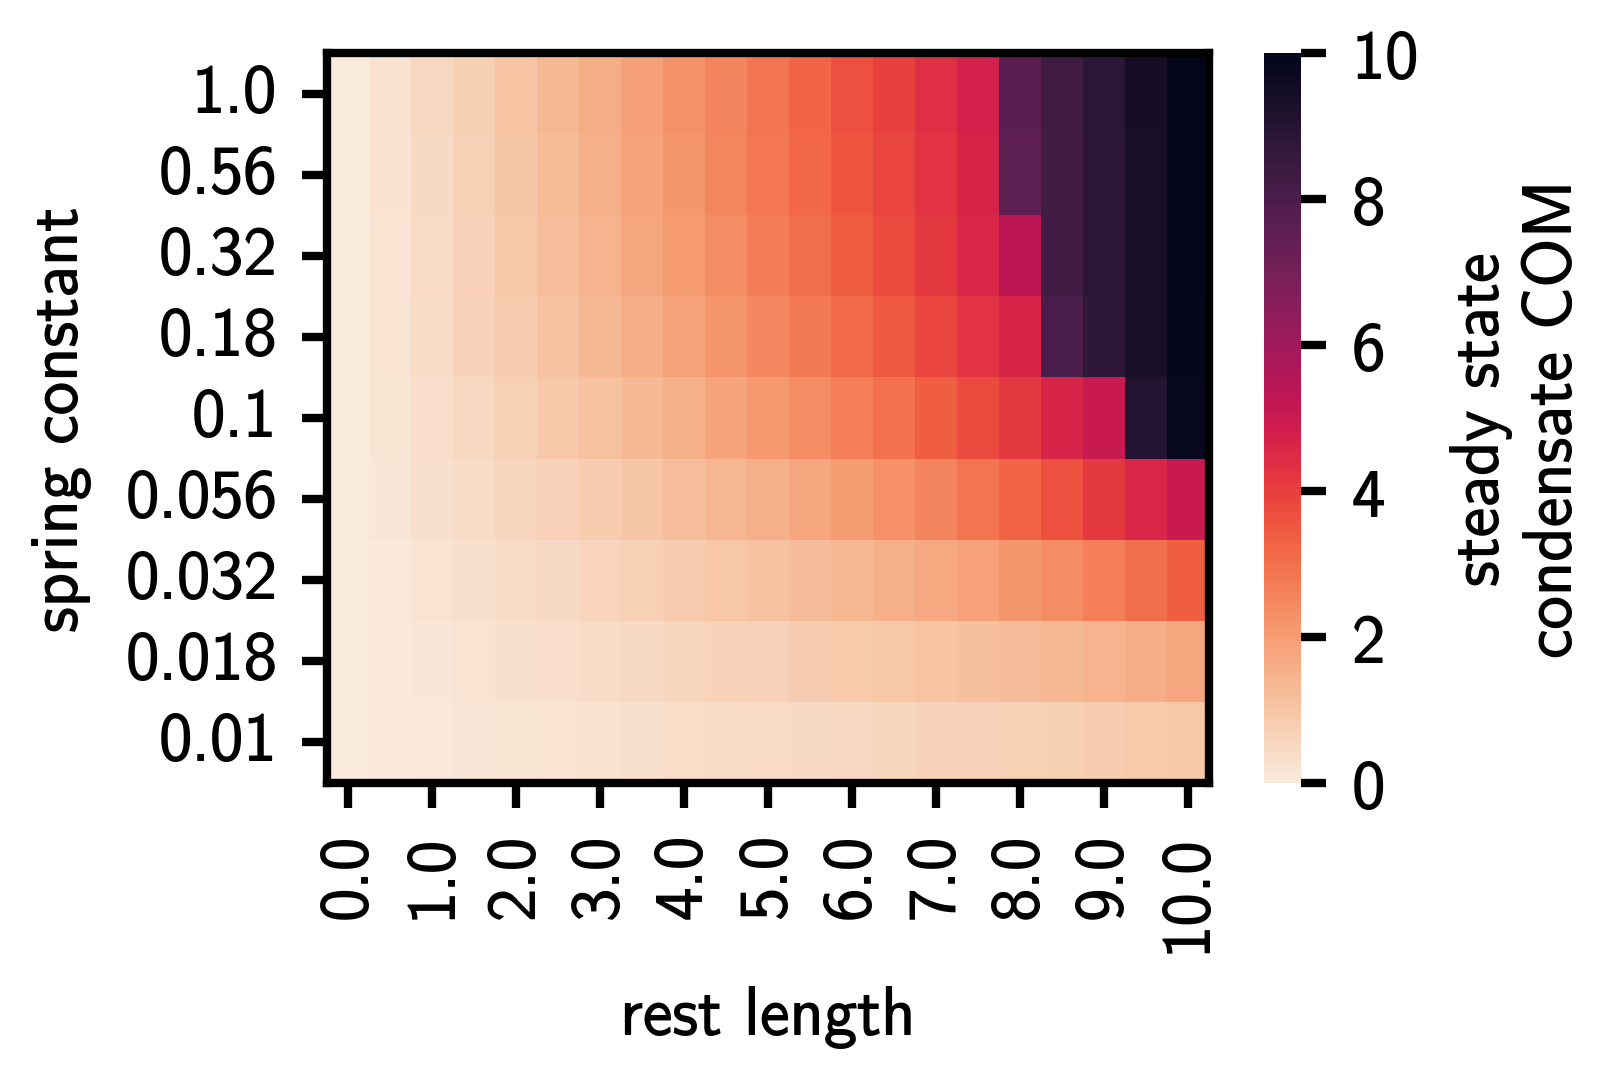

In [45]:
variable="condensate_com"
xlabel="rest length"
ylabel="spring constant"
cbarlabel="steady state\ncondensate COM"

fig, ax = plt.subplots()
scale = 0.7
fig.set_size_inches(get_size_inches(scale,scale*2/3))
pivot = spd.df.pivot(index="k_tilde",columns="rest_length",values=variable)
sns.heatmap(pivot, ax = ax,
            cbar_kws={'label': cbarlabel},
            cmap="rocket_r",
            vmin=0,
            vmax=10)
ax.invert_yaxis()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
for spine in ax.spines:
    ax.spines[spine].set_visible(True)
plt.savefig(_FIGURE_DIR / "Fig2_C_CondensatePosition")

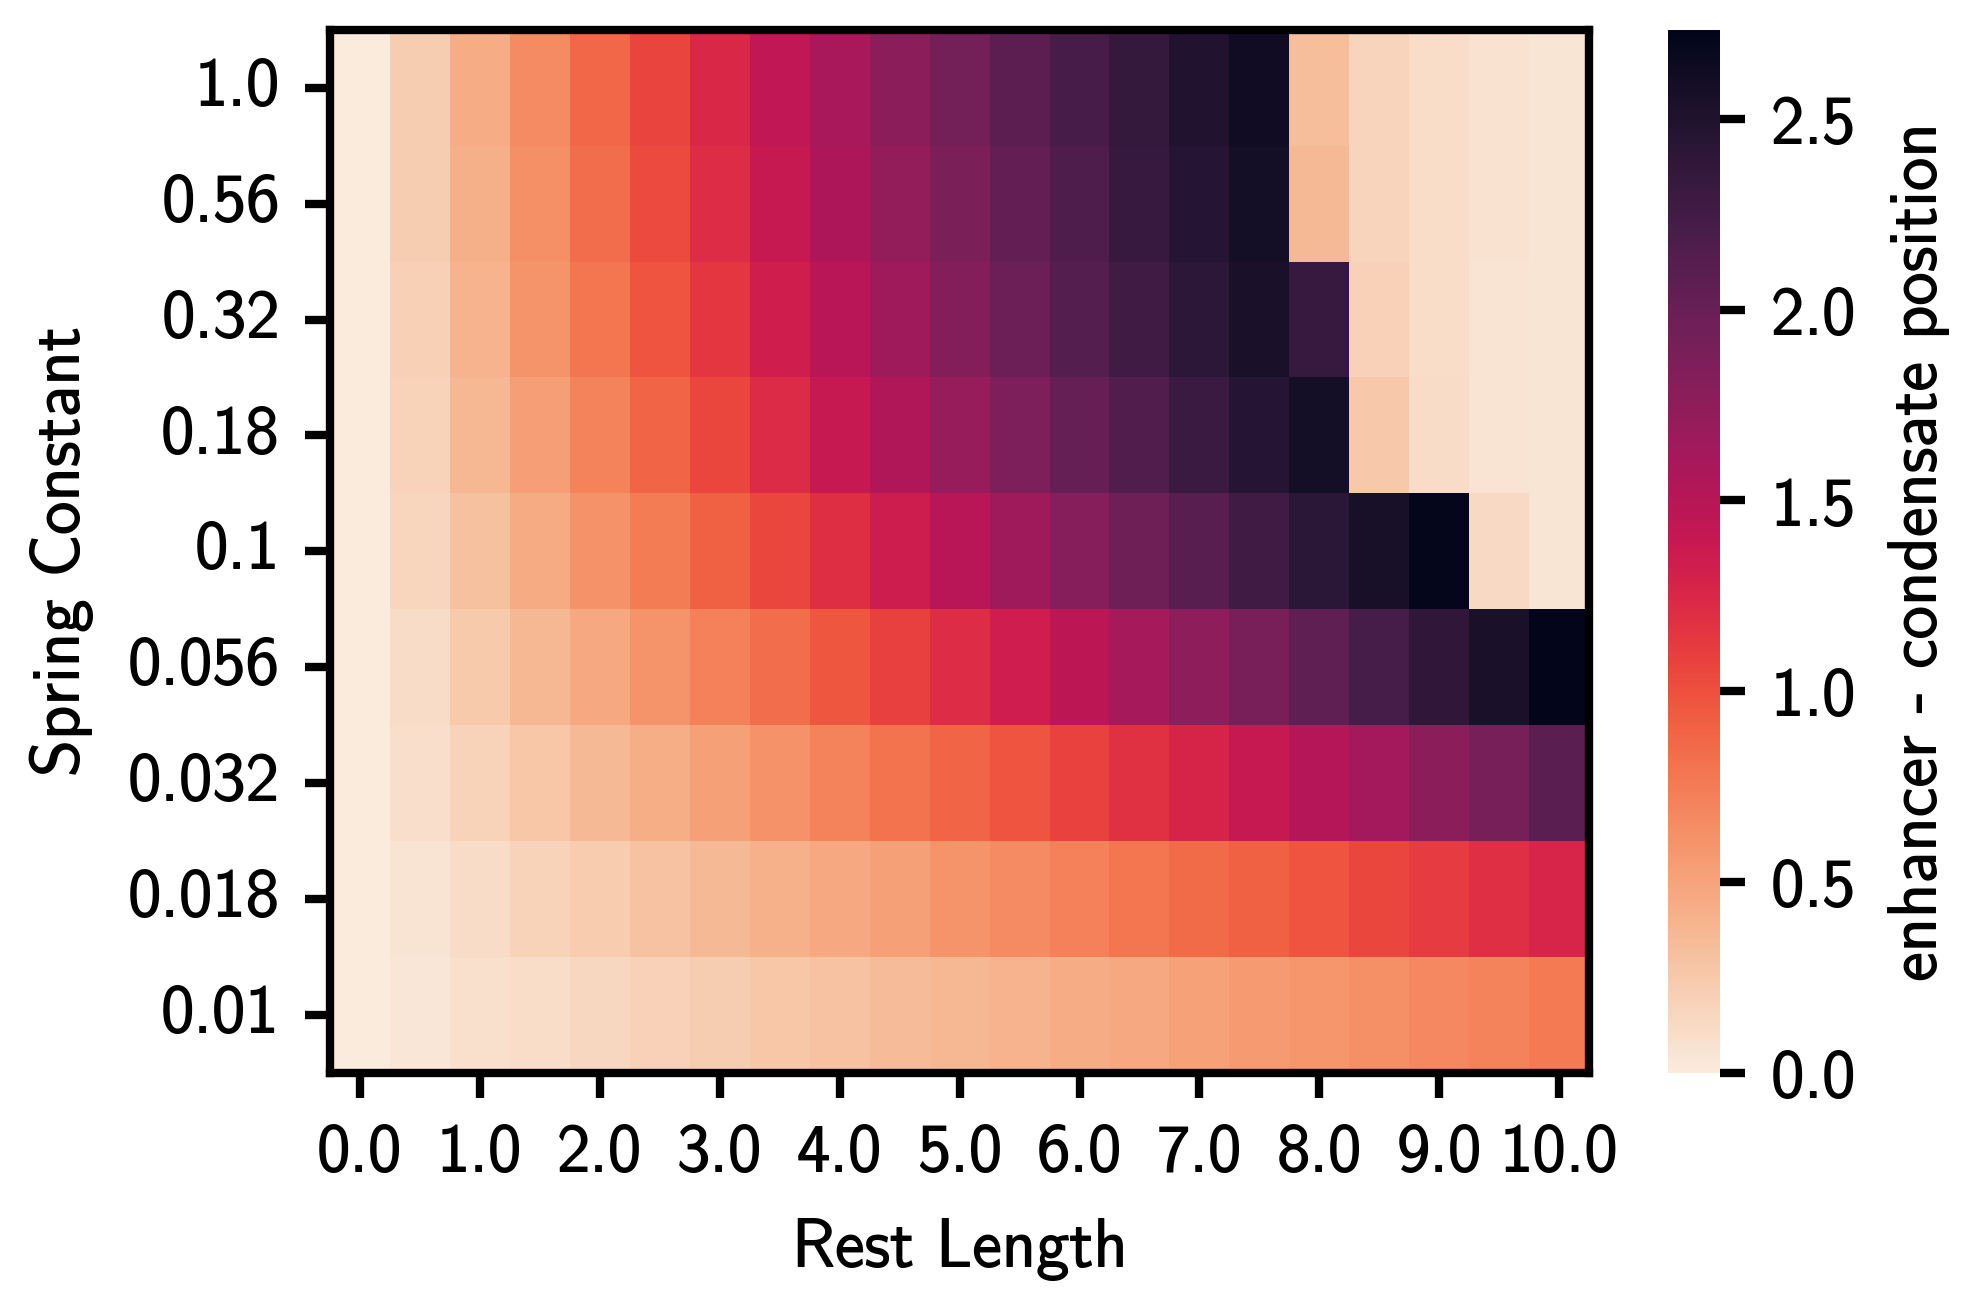

In [14]:
xlabel="Rest Length"
ylabel="Spring Constant"
cbarlabel='enhancer - condensate position'

fig, ax = plt.subplots()
pivot1 = spd.df.pivot(index="k_tilde",columns="rest_length",values="enhancer_loci")
pivot2 = spd.df.pivot(index="k_tilde",columns="rest_length",values="condensate_com")
sns.heatmap(pivot1-pivot2, ax = ax,
            cbar_kws={'label': cbarlabel},
            cmap="rocket_r",
            vmin=0)
ax.invert_yaxis()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
for spine in ax.spines:
    ax.spines[spine].set_visible(True)

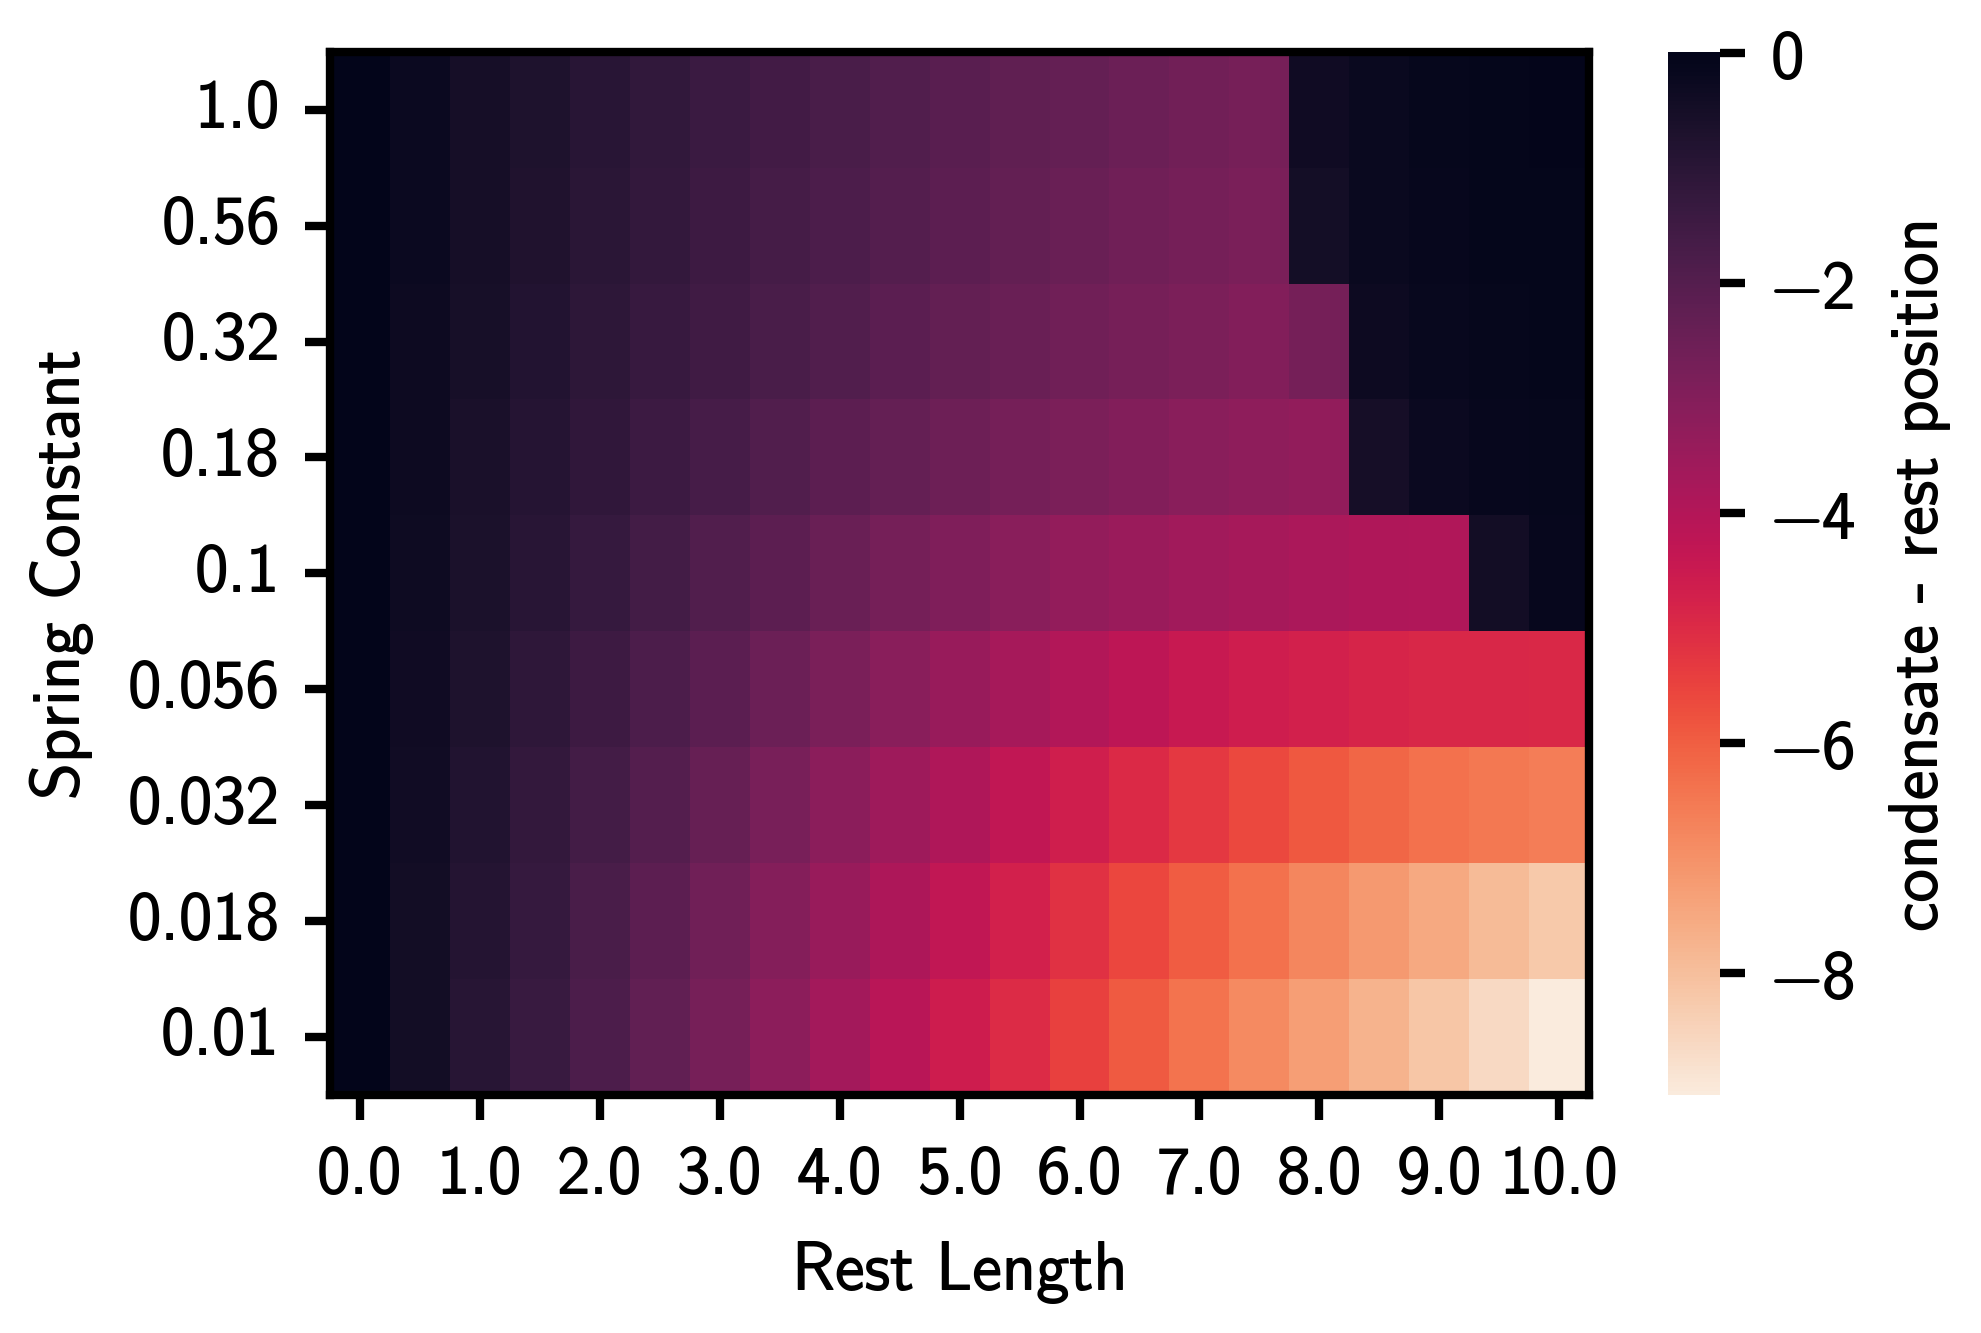

In [15]:
variable="condensate_com"
xlabel="Rest Length"
ylabel="Spring Constant"
cbarlabel="condensate - rest position"

fig, ax = plt.subplots()
pivot = spd.df.pivot(index="k_tilde",columns="rest_length",values=variable) - spd.df.pivot(index="k_tilde",columns="rest_length",values="rest_length").astype(np.float64)
sns.heatmap(pivot, ax = ax,
            cbar_kws={'label': cbarlabel},
            cmap="rocket_r",)
ax.invert_yaxis()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
for spine in ax.spines:
    ax.spines[spine].set_visible(True)
plt.savefig(_FIGURE_DIR / "Fig2_C_DeltaCondensatePosition")

NameError: name 'df' is not defined

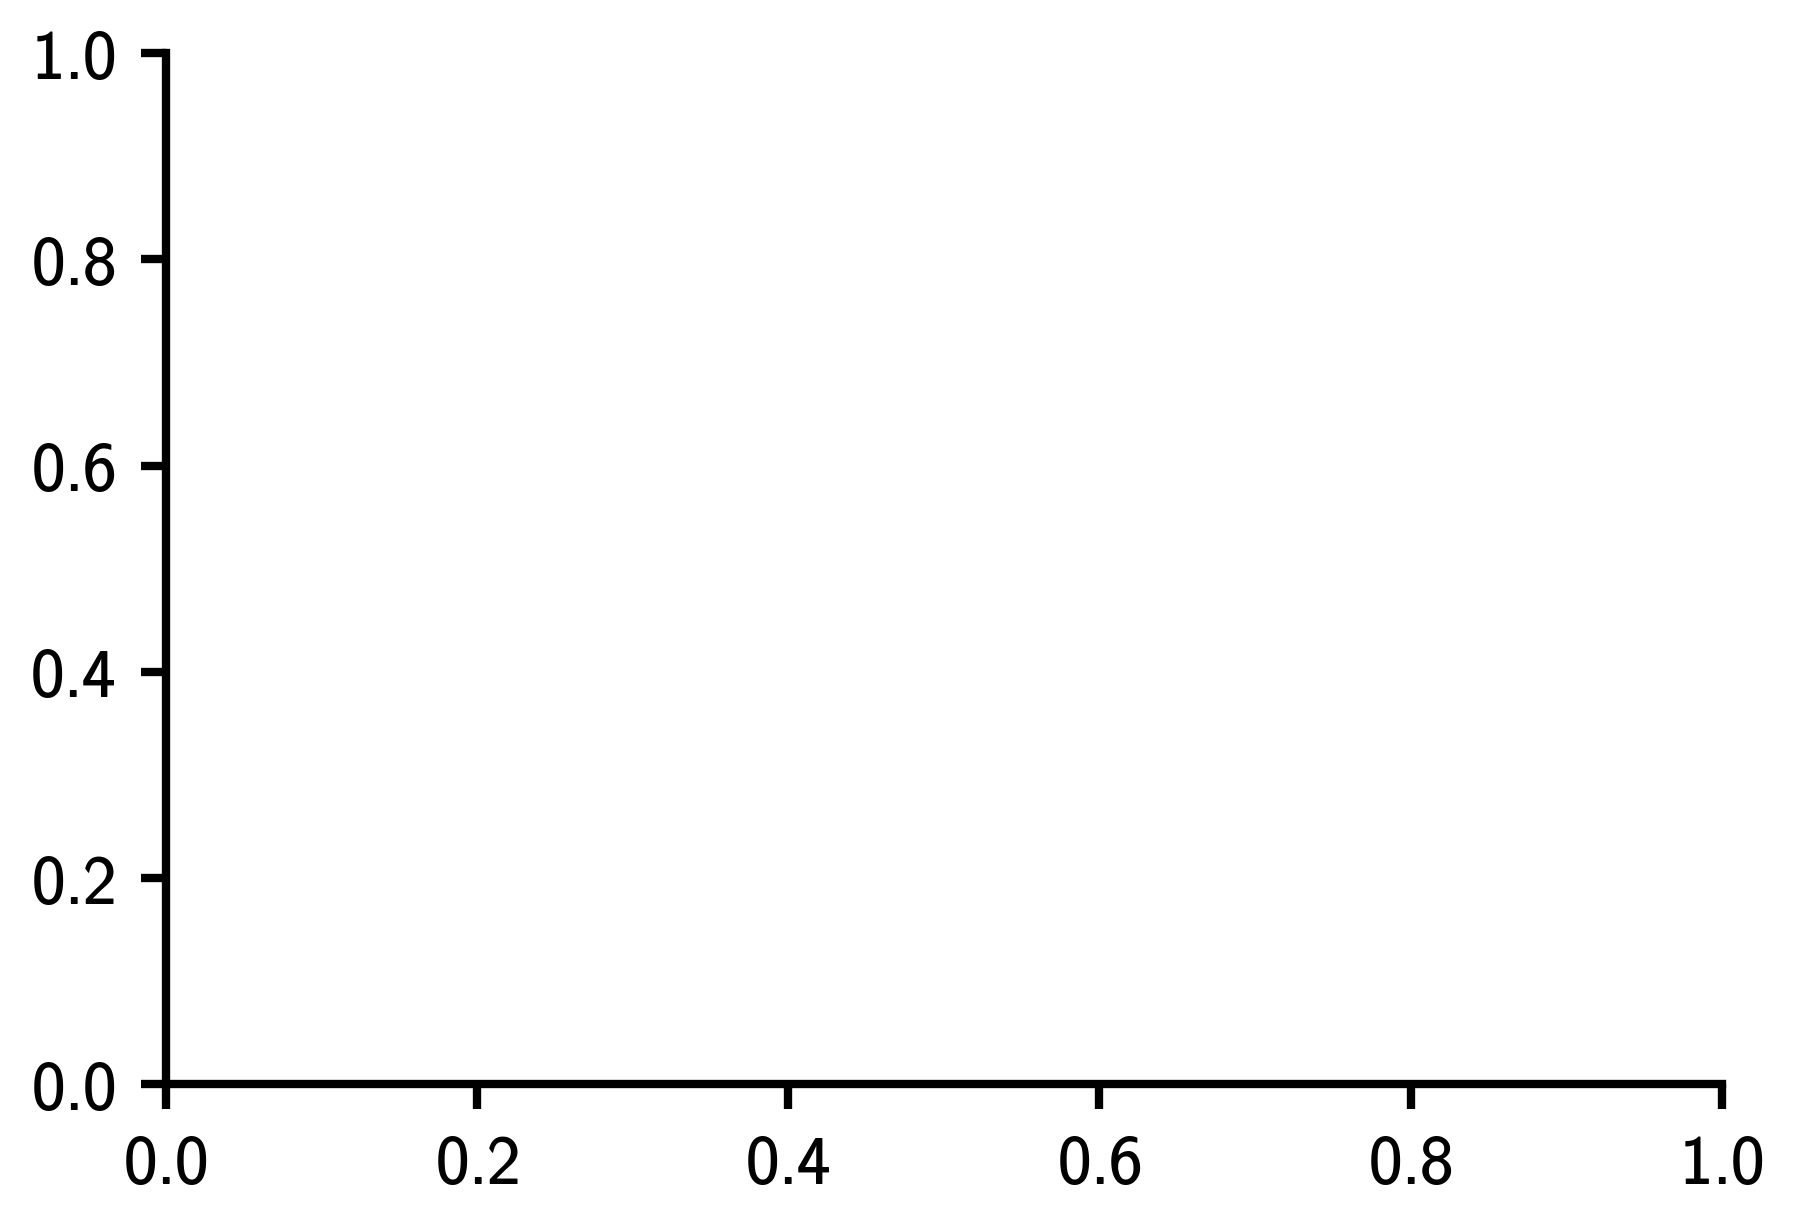

In [5]:
variable="aspect_ratio"
xlabel="Rest Length"
ylabel="Spring Constant (Log Scale)"
cbarlabel="Aspect Ratio"

fig, ax = plt.subplots()
pivot = df.pivot(index="k_tilde",columns="rest_length",values=variable)
sns.heatmap(pivot, ax = ax,
            cbar_kws={'label': cbarlabel})
ax.invert_yaxis()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
for spine in ax.spines:
    ax.spines[spine].set_visible(True)

In [49]:
mask_pivot = spd.df.pivot(index="k_tilde",columns="rest_length",values=["mask","concentration"])
mask_pivot = mask_pivot.iloc[::-1]

In [51]:
c_white_trans = mpl.colors.colorConverter.to_rgba('white',alpha = 0)
c_white= mpl.colors.colorConverter.to_rgba('white',alpha = 1)
c_black_trans = mpl.colors.colorConverter.to_rgba('black',alpha = 0)
c_black= mpl.colors.colorConverter.to_rgba('black',alpha = 1)
cmap_black = mpl.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_black_trans,c_black],512)
cmap = mpl.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_white_trans,c_white],512)
def shape(xy,c,ax,cmap=cmap):
    x = xy[:,0]
    y = xy[:,1]
    ax.tricontourf(x,y,c,cmap=cmap)
    ax.set_aspect(1)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
        ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False)

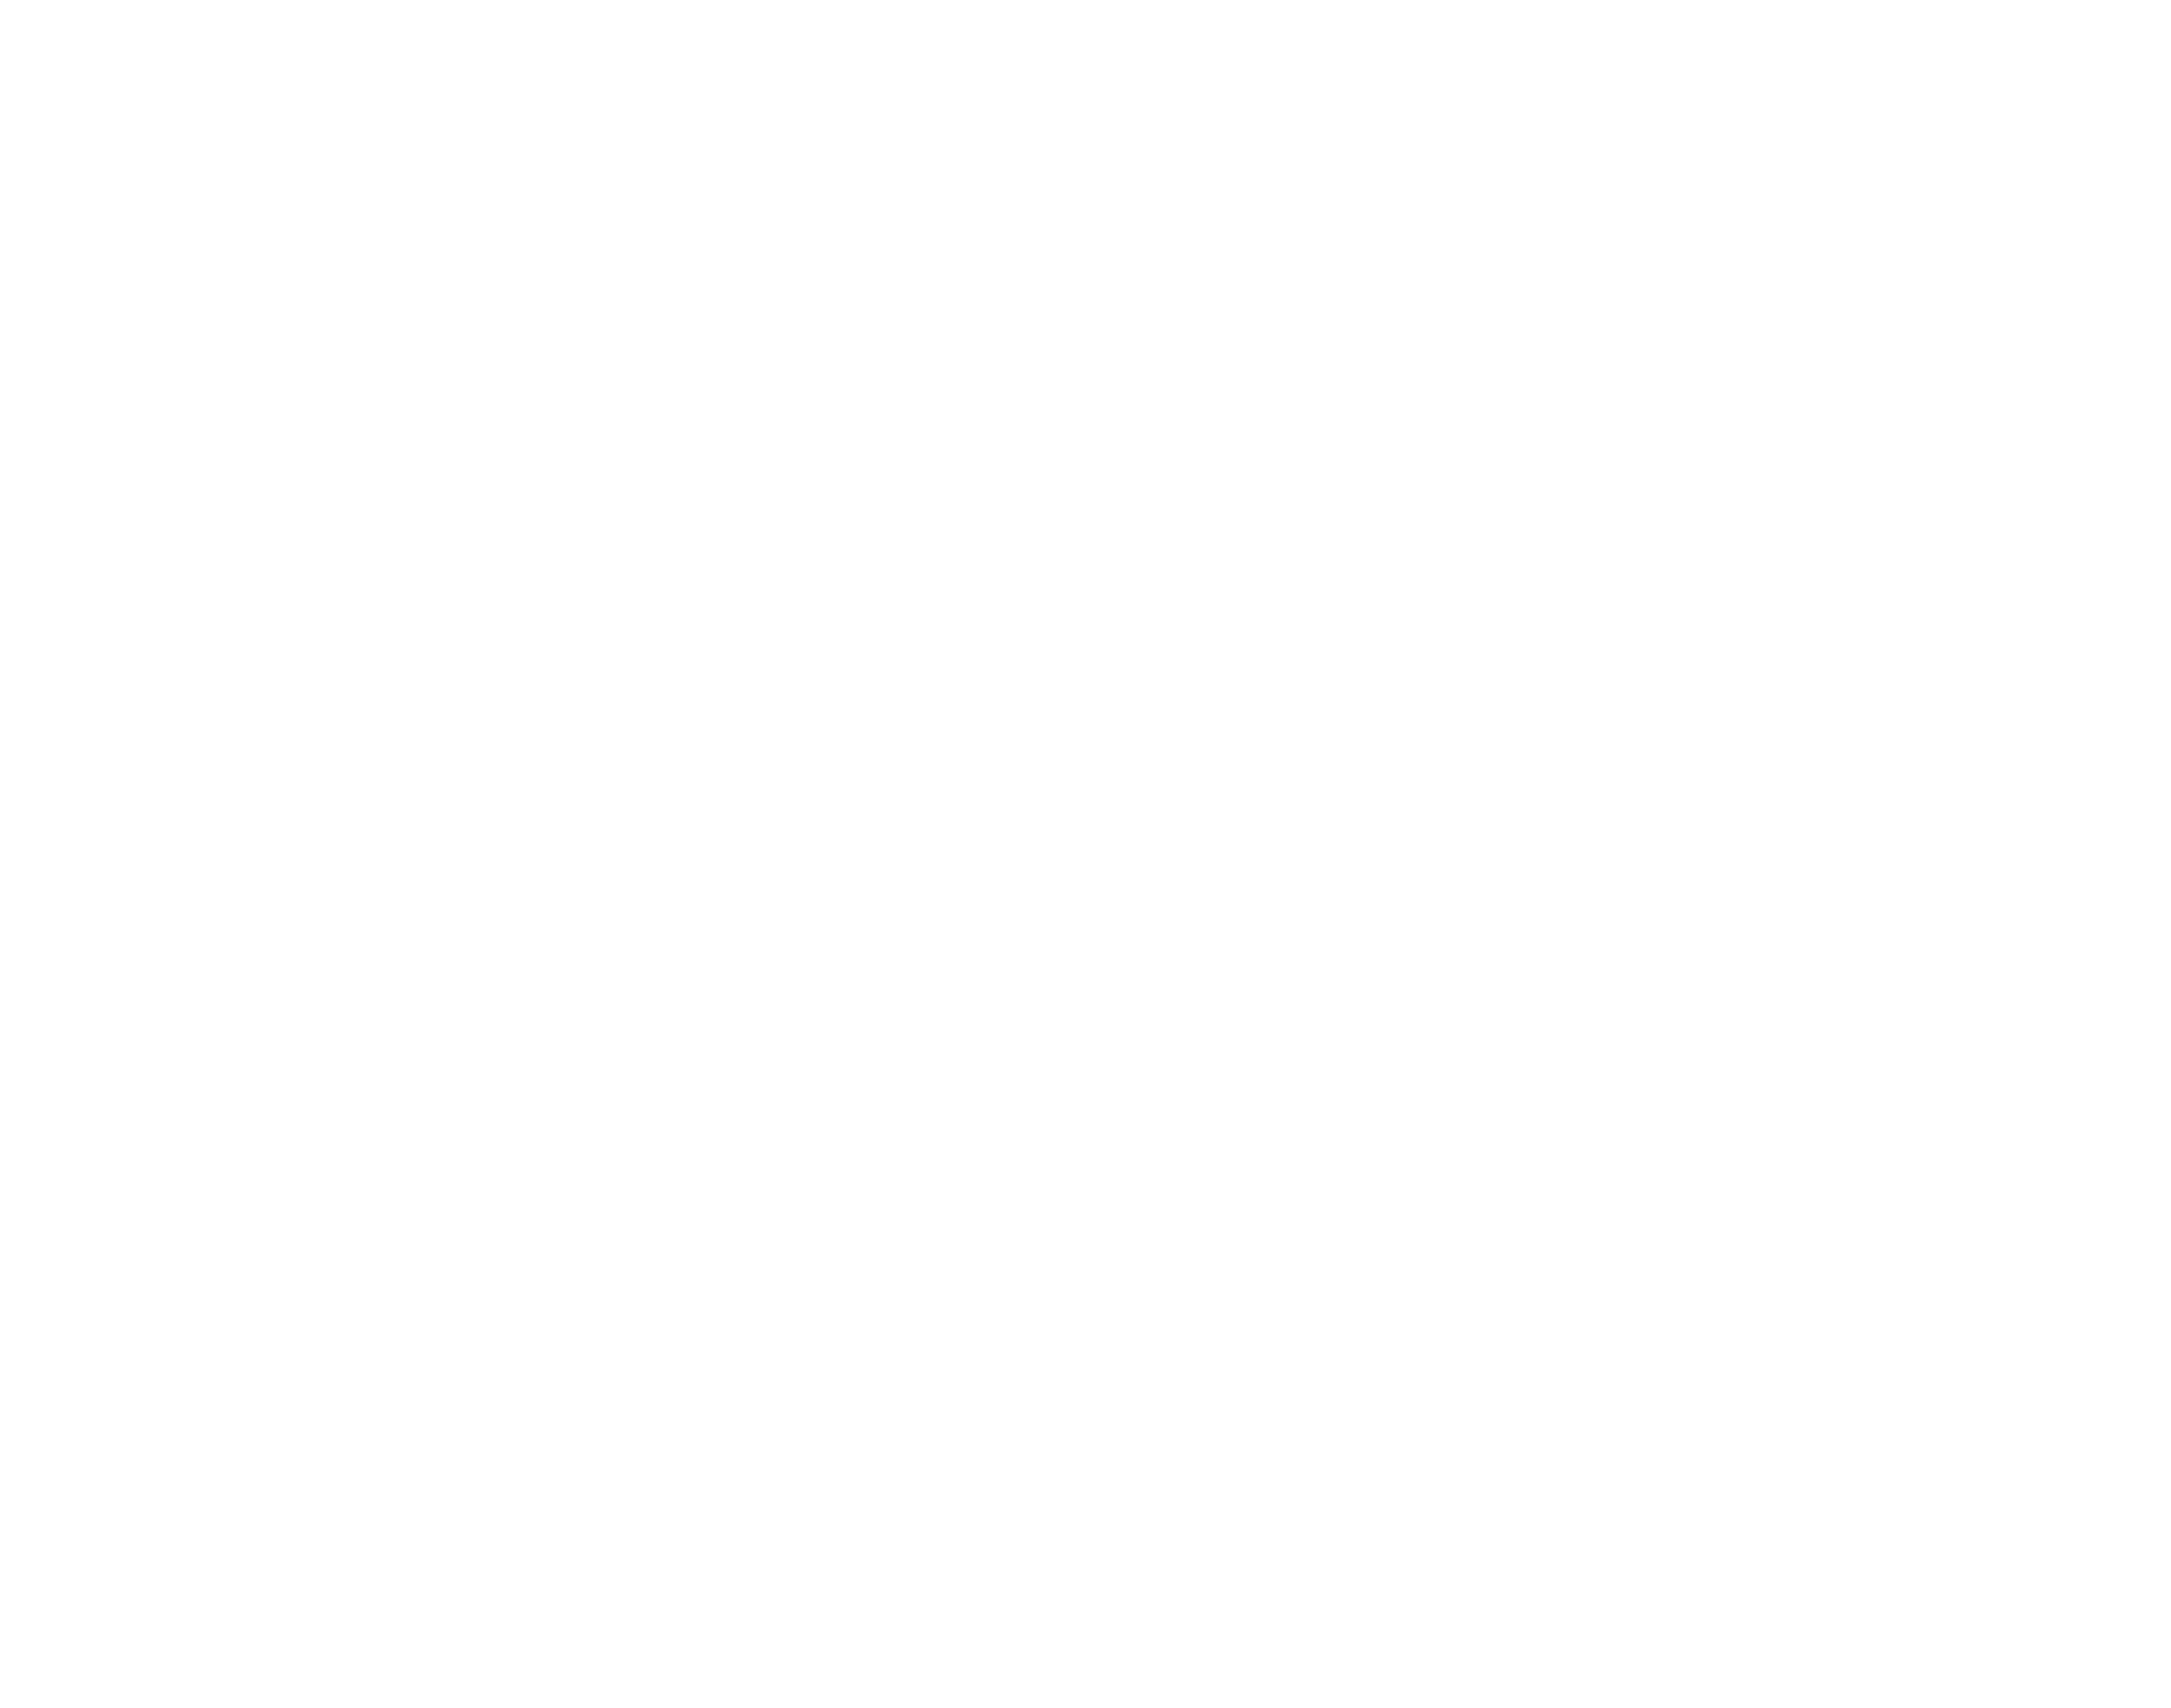

In [55]:
fig,axes=plt.subplots(len(mask_pivot["mask"].index),len(mask_pivot["mask"].columns))
cm_in_inch = 2.54
fig.set_size_inches(3.696*cm_in_inch, 3.055*cm_in_inch)
for ax,arr_xy,arr_c in zip(axes.flatten(),
                           mask_pivot["mask",].to_numpy().flatten(),
                           mask_pivot["concentration",].to_numpy().flatten()):
    shape(arr_xy,arr_c,ax,cmap)
plt.savefig(_FIGURE_DIR / "Fig2_C_Mask")

In [6]:
spd = springPhaseDiagram(root/"20240123_PhaseDiagramFixedAccurateMobilityFocus")
# spd.extract_data(119)
# spd.df.to_pickle("20240123_PhaseDiagramFixedAccurateMobilityFocus.pkl")

In [7]:
spd.df = pd.read_pickle("20240127_PhaseDiagramFixedAccurateMobilityHigher.pkl")

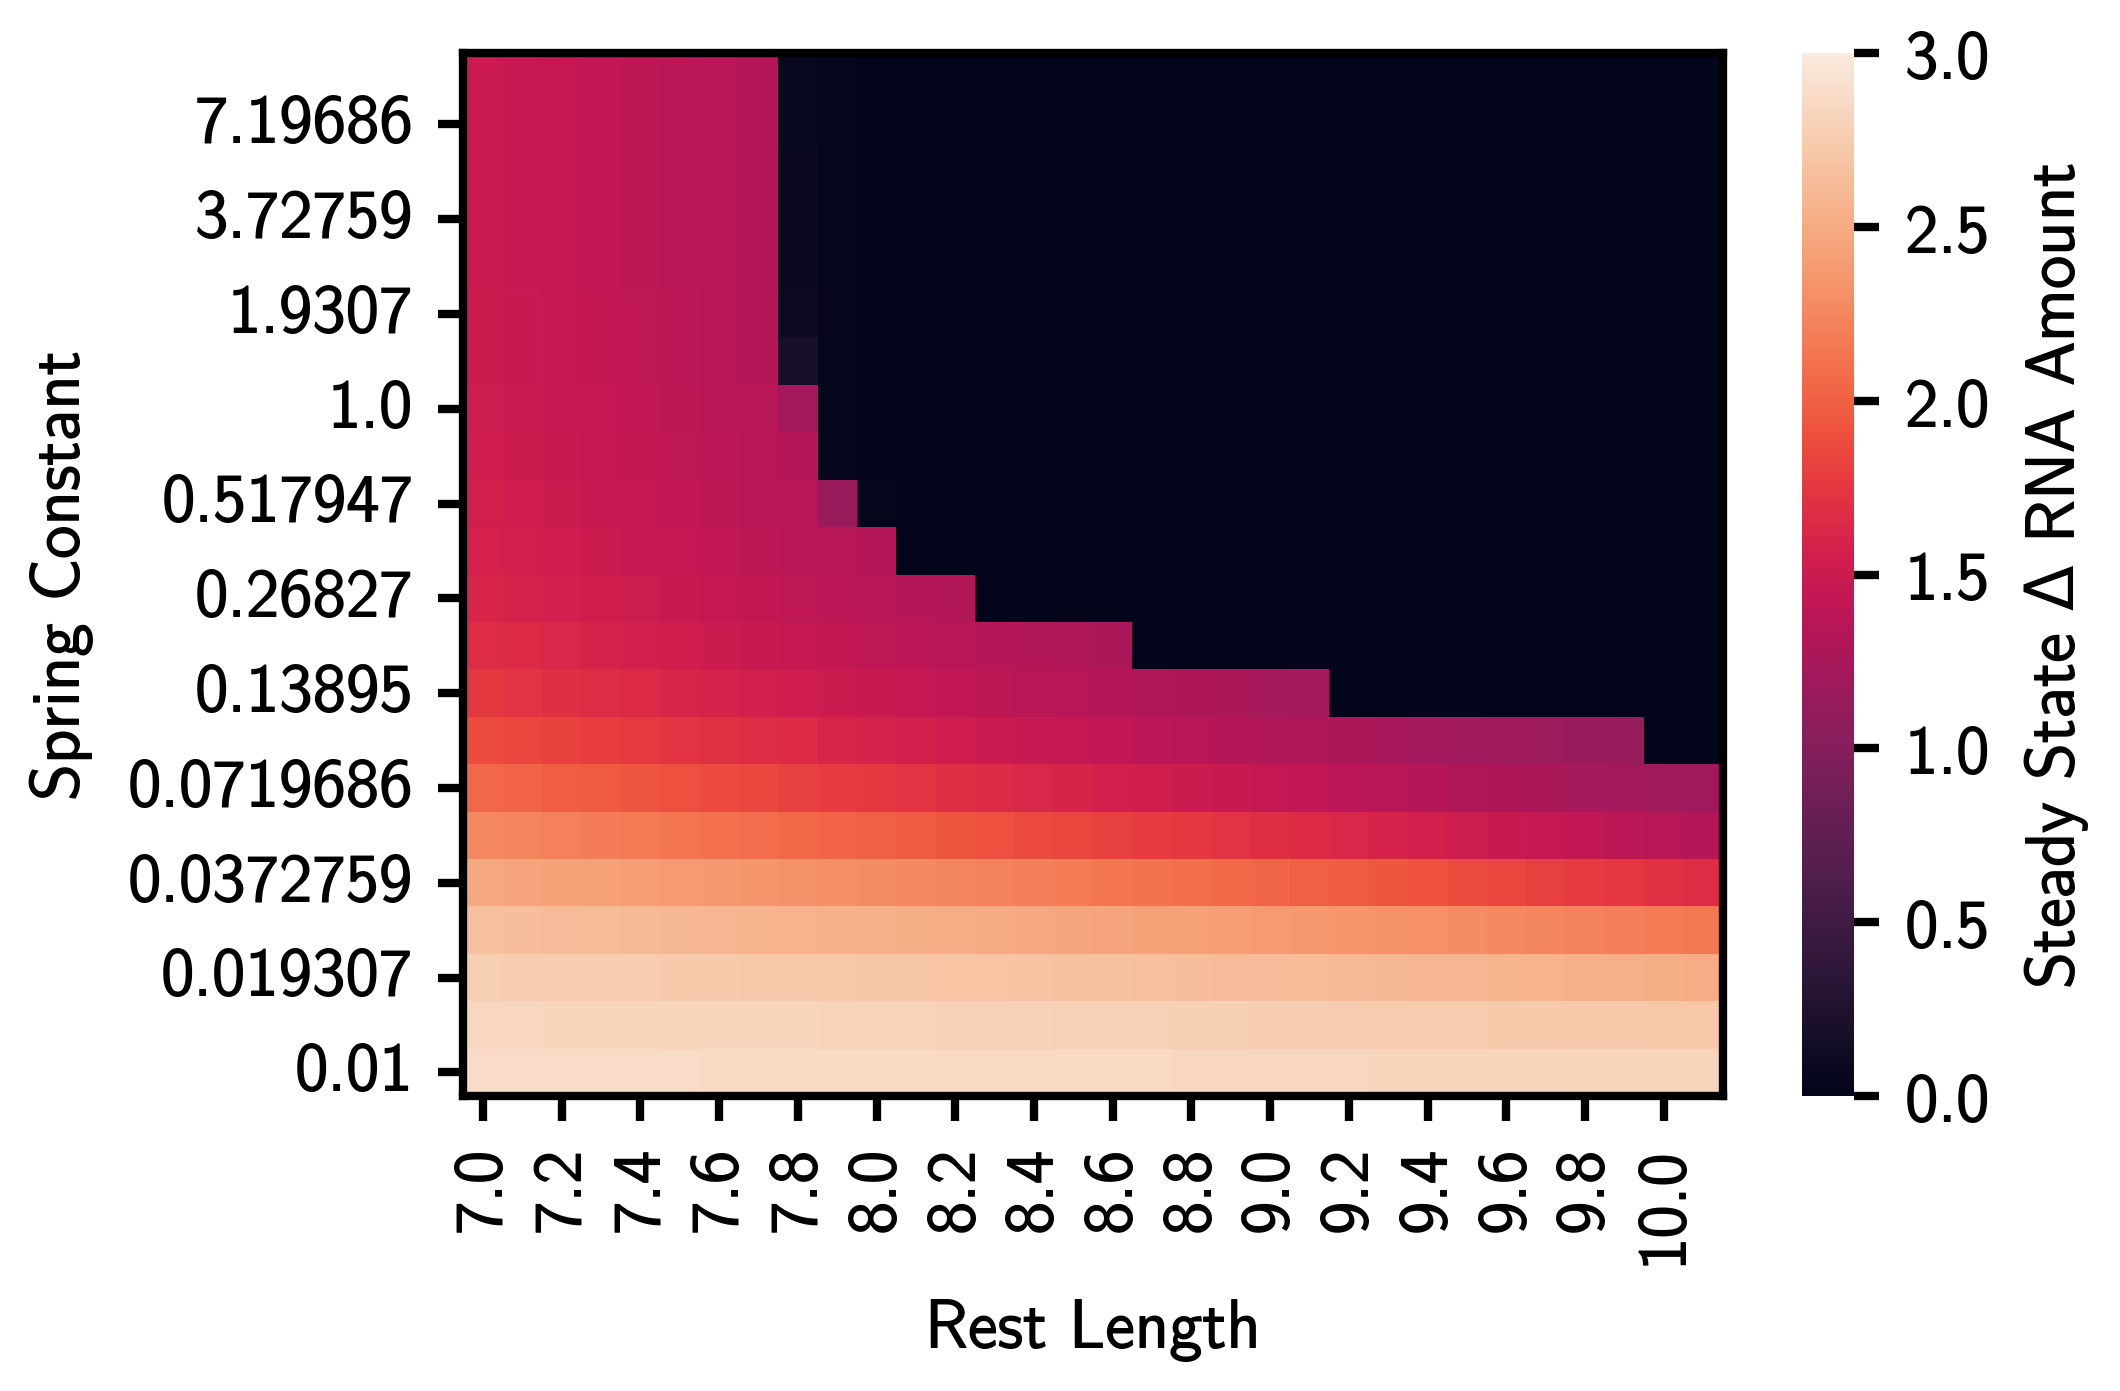

In [ ]:
variable="rna_amount"
xlabel="Rest Length"
ylabel="Spring Constant"
cbarlabel='Steady State $\Delta$ RNA Amount'

fig, ax = plt.subplots()
pivot = spd.df.pivot(index="k_tilde",columns="rest_length",values=variable)
sns.heatmap(pivot-no_condensate_rna, ax = ax,
            cbar_kws={'label': cbarlabel},
            vmin=0,vmax=3)
ax.invert_yaxis()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
for spine in ax.spines:
    ax.spines[spine].set_visible(True)


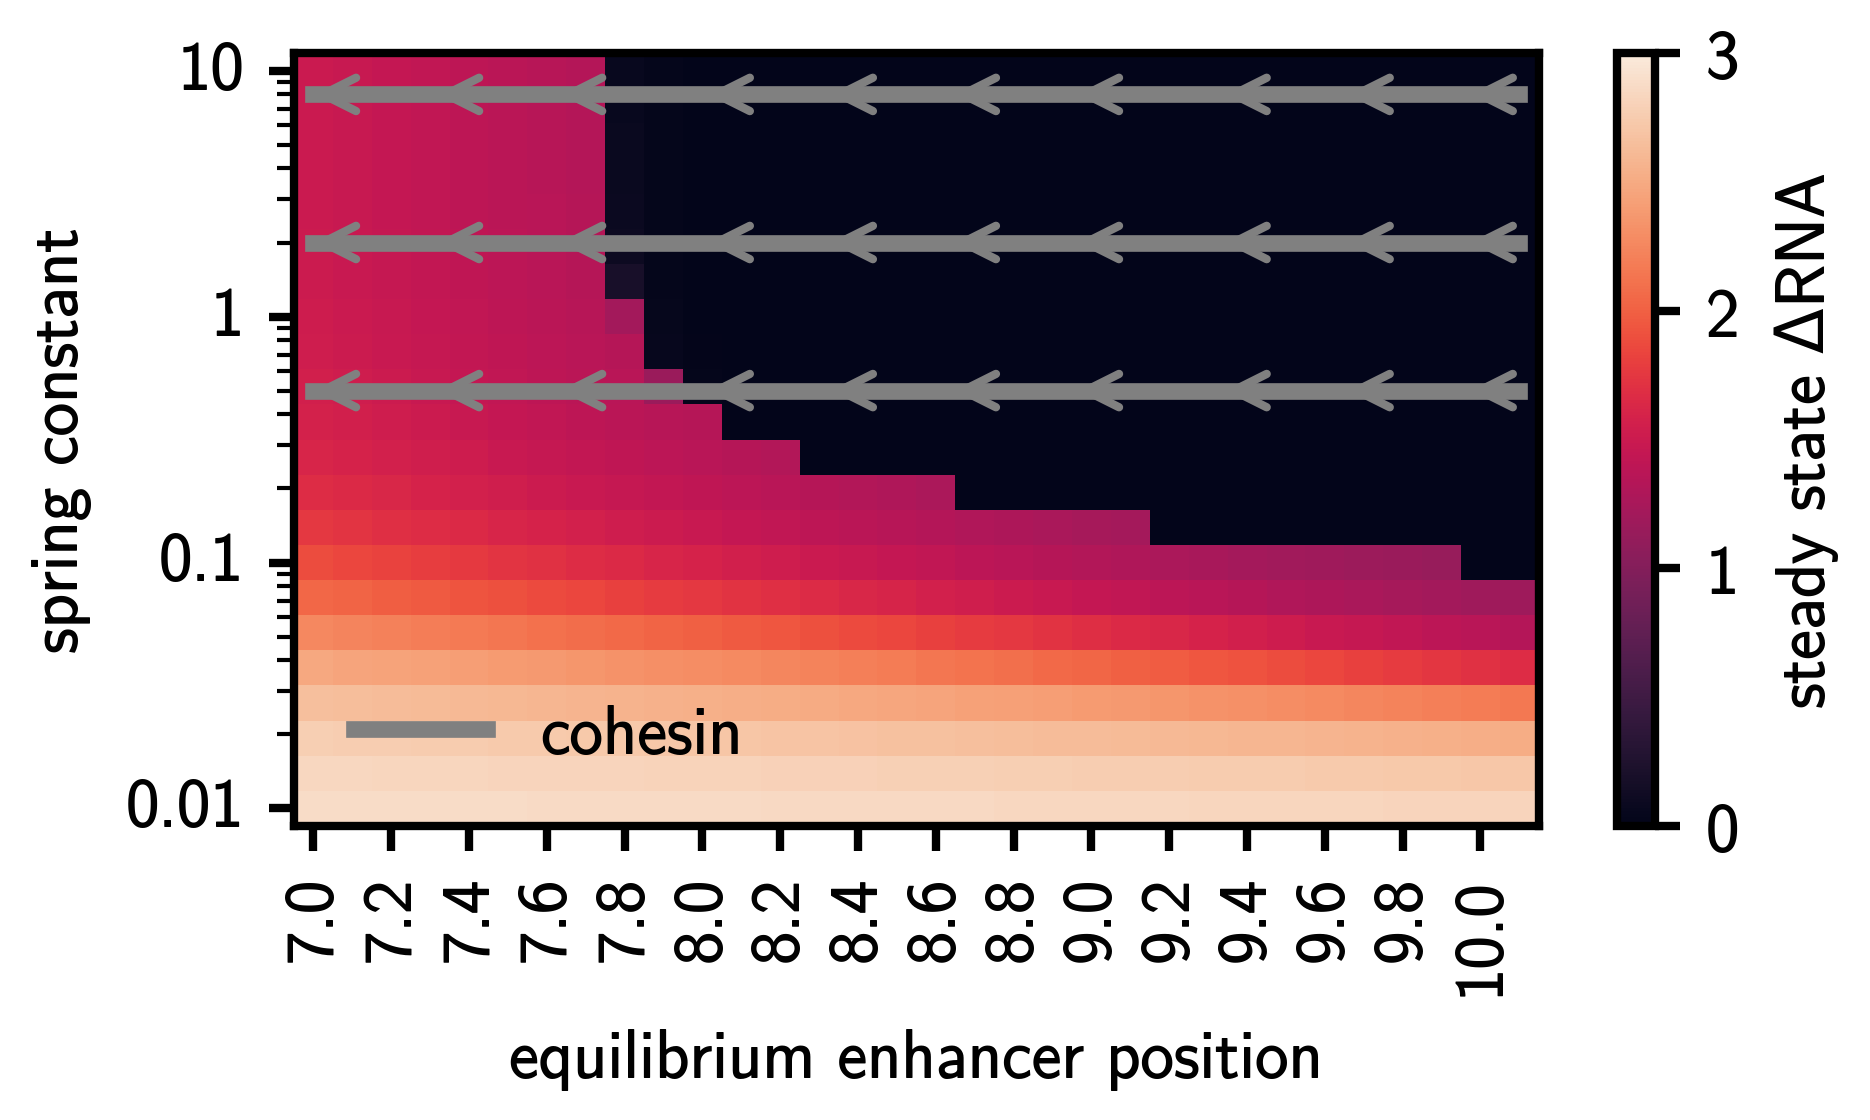

In [9]:
variable="rna_amount"
xlabel="equilibrium enhancer position"
ylabel="spring constant"
cbarlabel='steady state $\Delta$RNA'

fig, ax = plt.subplots()
scale = 0.7
# fig.set_size_inches(get_size_inches(scale,scale*2/3))
fig.set_size_inches(get_size_inches(1,2/4))
pivot = spd.df.pivot(index="k_tilde",columns="rest_length",values=variable)
g = sns.heatmap(pivot-no_condensate_rna, ax = ax,
            cbar_kws={'label': cbarlabel},
            vmin=0,vmax=3)
ax.invert_yaxis()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
for spine in ax.spines:
    ax.spines[spine].set_visible(True)

cb = ax.collections[0].colorbar
cb.outline.set_color('black')
cb.outline.set_linewidth(1)

for c in np.logspace(np.log10(0.5),np.log10(8),3):
    line_x = np.linspace(7,10.1)
    line_y = c/np.ones(np.shape(line_x))**2

    x_min, x_max = pivot.columns.min(), pivot.columns.max()
    mapped_x = (line_x - x_min) / (x_max - x_min) * (len(pivot.columns) - 1)+0.5

    # Map y coordinates (logarithmic scale)
    y_min, y_max = np.log(pivot.index.min()), np.log(pivot.index.max())
    mapped_y = (np.log(line_y) - y_min) / (y_max - y_min) * (len(pivot.index) - 1)+0.5
    # "Cohesin isotherm\n"r"$k\propto \frac{1}{R_0^2}$"
    line, = ax.plot(mapped_x,mapped_y,color="grey",label="cohesin")
    plot.add_arrow(line,direction='left',size=10)

def map_y(y):
    return (np.log(y) - y_min) / (y_max - y_min) * (len(pivot.index) - 1)+0.5

ax.yaxis.set_minor_locator(ticker.FixedLocator(map_y(generate_linlog_sequence(0.01,10))))
ax.set_yticks(map_y(np.array([0.01,0.1,1,10])))
# ax.set_yticklabels([f"$10^{{{i}}}$" for i in [-2,-1,0,1]])
ax.set_yticklabels([10**i for i in [-2,-1,0,1]])
ax.legend([label if i==0 else '_' for i, label in enumerate(ax.get_legend_handles_labels()[1])],
          loc="lower left")
plt.savefig(_FIGURE_DIR / "Fig2_B_TranscriptionEnhancement")

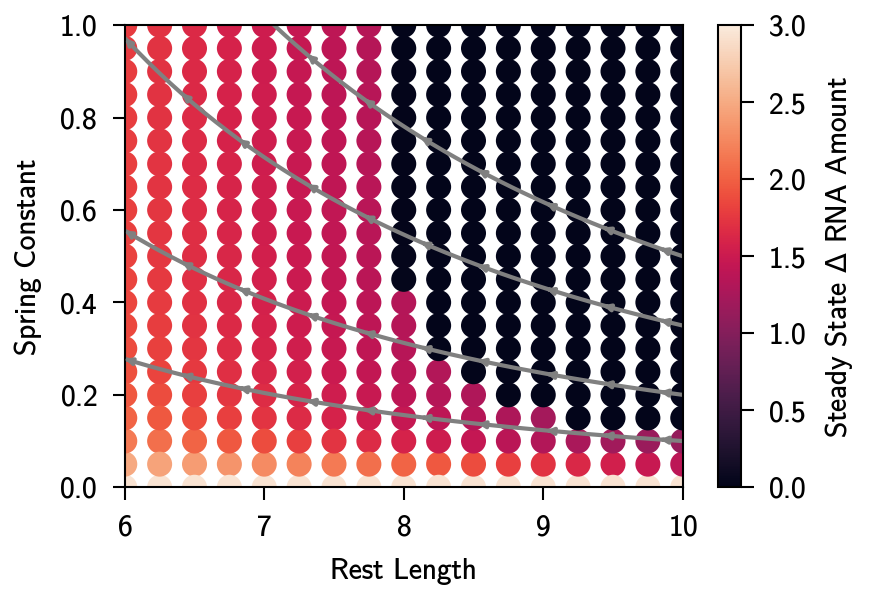

In [ ]:
variable="rna_amount"
xlabel="Rest Length"
ylabel="Spring Constant"
cbarlabel='Steady State $\Delta$ RNA Amount'

fig, ax = plt.subplots()
im = ax.scatter(x=df["rest_length"],
            y=df["k_tilde"],
            c=df["rna_amount"]-no_condensate_rna,
            cmap="rocket",
            s=25,
            vmin=0,
            vmax=3)
fig.colorbar(im, ax=ax, label=cbarlabel)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_xlim([6,10])
ax.set_ylim([0,1])
for spine in ax.spines:
    ax.spines[spine].set_visible(True)

for c in [10,20,35,50]:
    x = np.linspace(6,10)
    line, = ax.plot(x,c/x**2,color="grey")
    plot.add_arrow(line,direction='left')

In [ ]:
def frameFigure(sim,
                   i:int,
                   t:int):
    fig,ax = plt.subplots()
    cs = ax.tricontourf(sim.geometry.mesh.x,
                        sim.geometry.mesh.y,
                        sim.concentration_profile[i][t],
                        vmin = 3.5,
                        vmax = 5,
                        cmap=sim.movie_params['color_map'][i])
    ax.autoscale_view()
    ax.xaxis.set_tick_params(labelbottom=False, bottom=False)
    ax.yaxis.set_tick_params(labelleft=False, left=False)
    ax.set_aspect('equal', 'box')
    plt.setp(ax.spines.values(), visible=False)
    return fig,ax

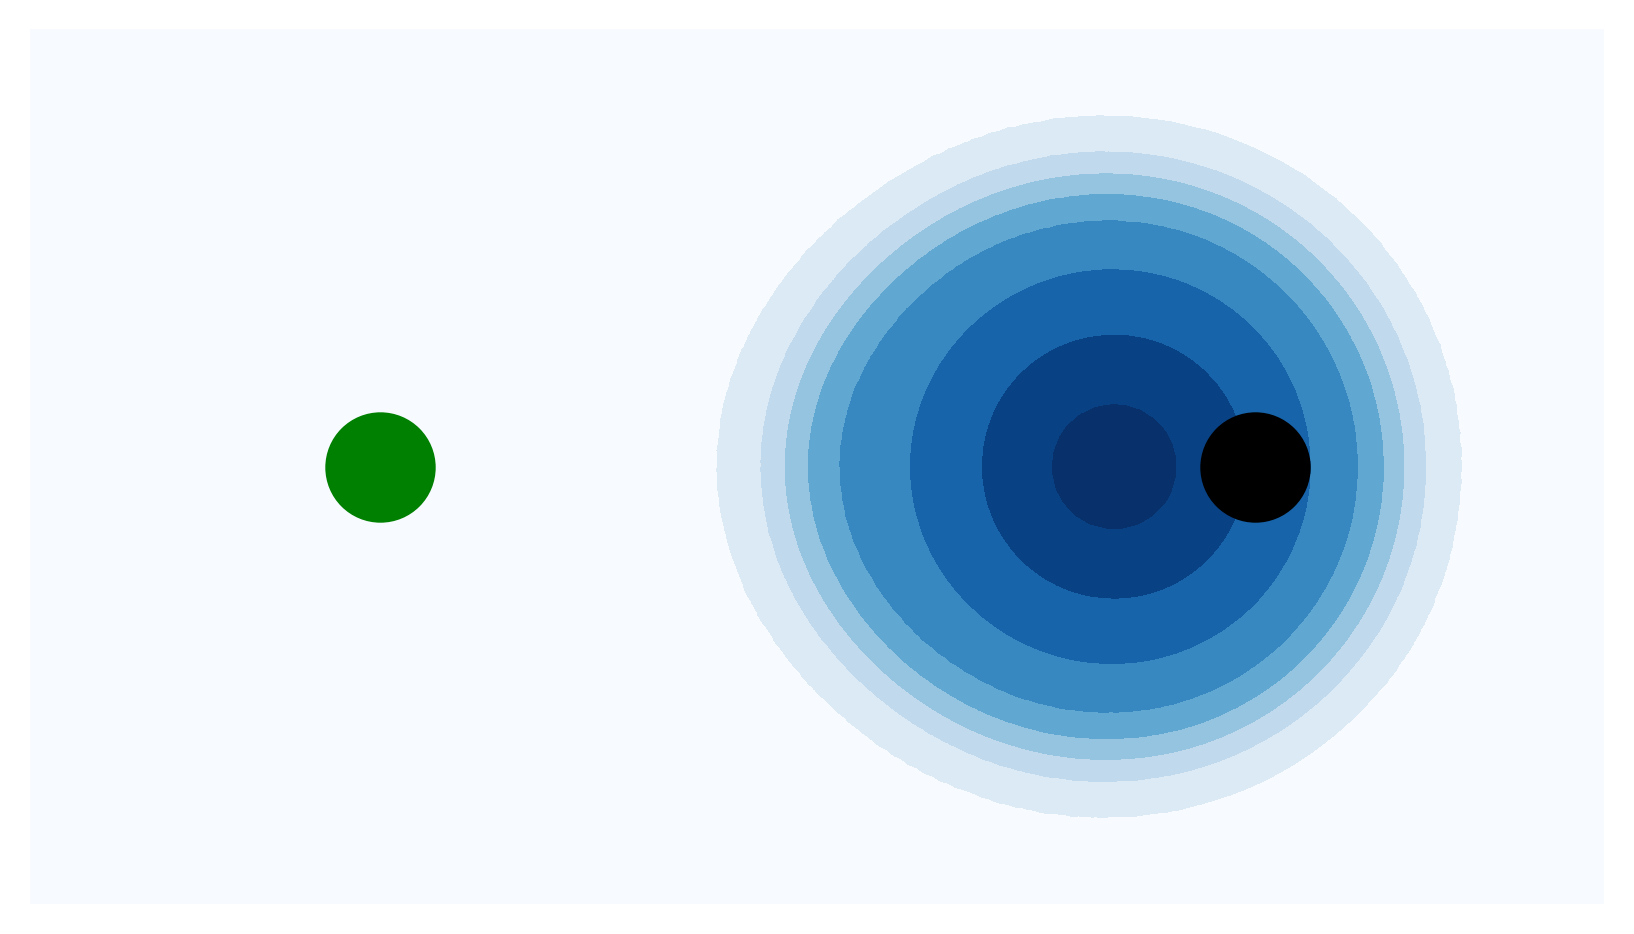

In [ ]:
sim = simDir("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/04_CoupledFlow/20240122_PhaseDiagramFixedAccurateMobility/M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_0.1_c1_3.53_sw_1.0_sr_2.5_cn_5.5_l_6_M3_0.1_kt_0.32_rl_8.5_wd_1.0")
sim.run()
enhancer_r = pd.read_csv(sim.directory/"stats.txt",delimiter=r'\t')["well_center_x"].iloc[-1]
fig, ax = frameFigure(sim,i=0,t=-1)
ax.set_ylim(-5,5)
ax.set_xlim(left=-4,right=14)
ax.scatter(x=0, y=0, s=600, color='green',marker=".")
ax.scatter(x=10, y=0, s=600, color='black',marker=".")
ax.scatter(x=enhancer_r, y=0, s=600, color='#08306b',marker=".")
fig.savefig(_FIGURE_DIR/"Fig2_C_Right")

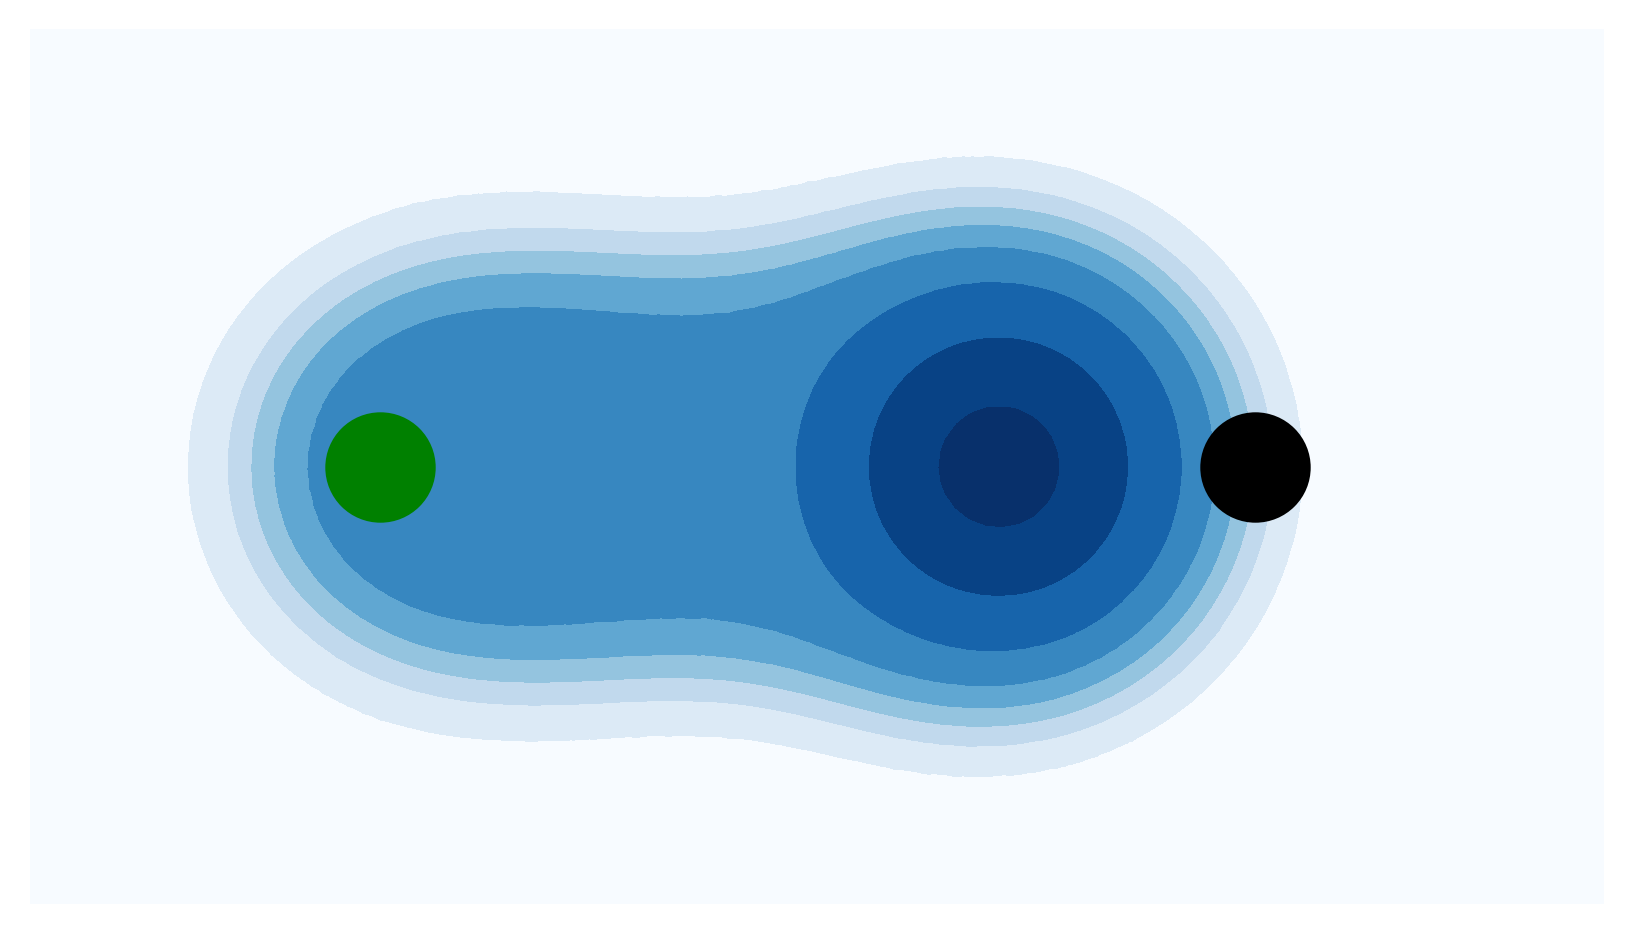

In [ ]:
sim = simDir("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/04_CoupledFlow/20240122_PhaseDiagramFixedAccurateMobility/M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_0.1_c1_3.53_sw_1.0_sr_2.5_cn_5.5_l_6_M3_0.1_kt_0.32_rl_7.5_wd_1.0")
sim.run()
enhancer_r = pd.read_csv(sim.directory/"stats.txt",delimiter=r'\t')["well_center_x"].iloc[-1]
fig, ax = frameFigure(sim, i=0,t=-1)
ax.set_ylim(-5,5)
ax.set_xlim(left=-4,right=14)
ax.scatter(x=0, y=0, s=600, color='green',marker=".")
ax.scatter(x=10, y=0, s=600, color='black',marker=".")
ax.scatter(x=enhancer_r, y=0, s=600, color='#08306b',marker=".")
fig.savefig(_FIGURE_DIR/"Fig2_C_Pinch")

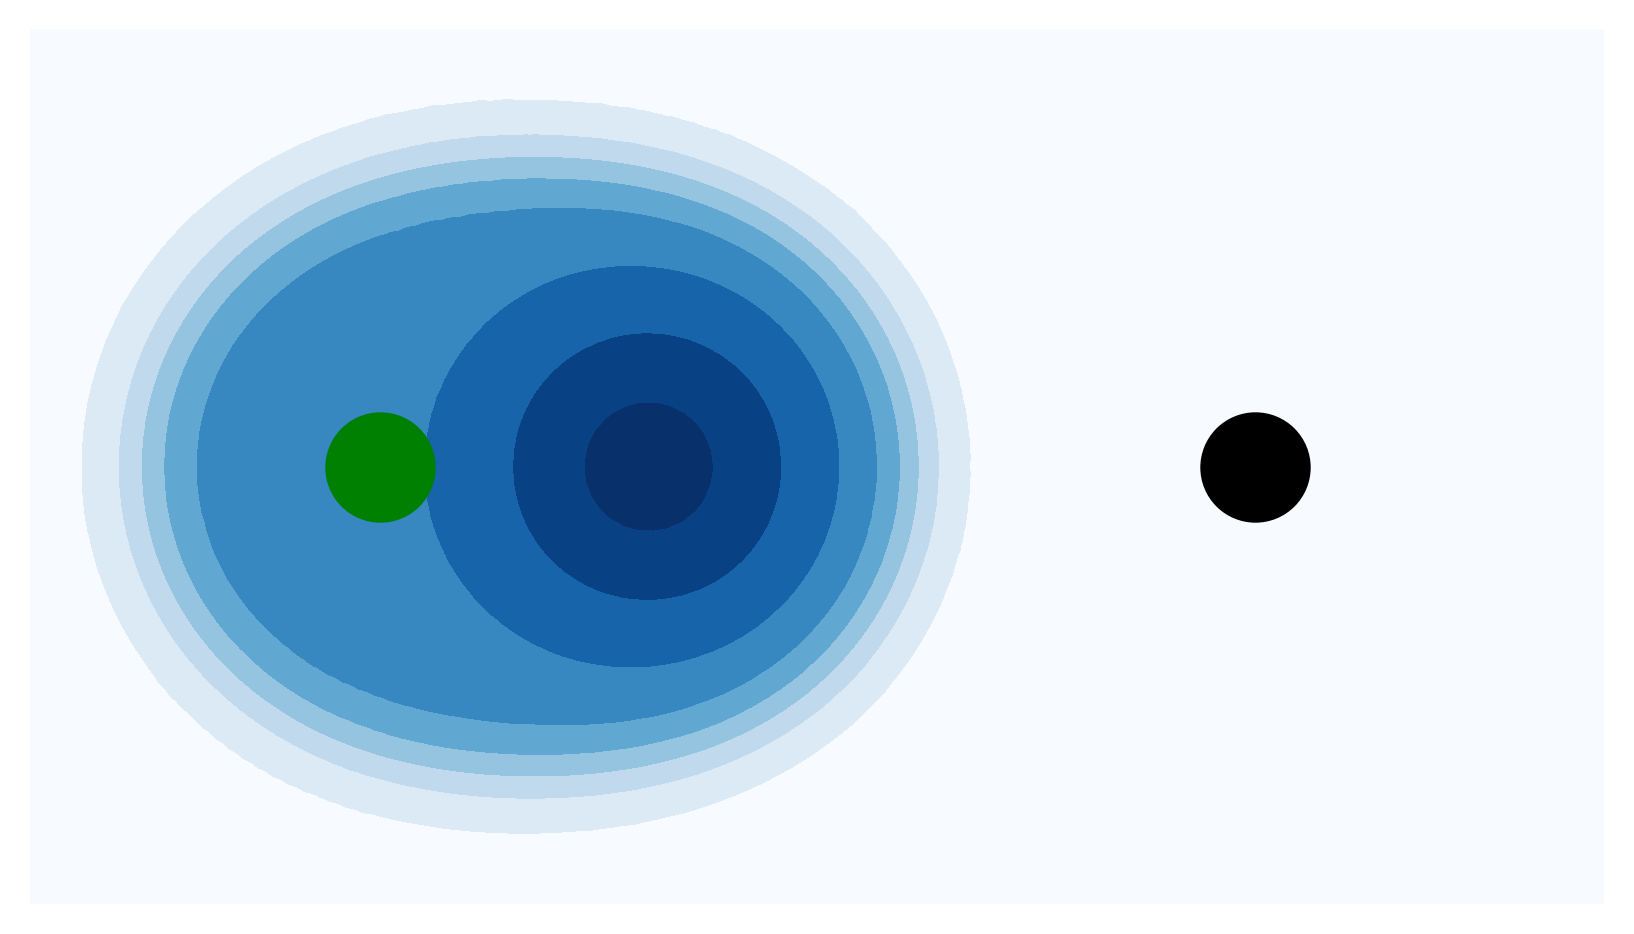

In [ ]:
sim = simDir("/nfs/arupclab001/davidgoh/CoupledEPCondensates/workspace/04_CoupledFlow/20240122_PhaseDiagramFixedAccurateMobility/M1_1.0_b_-0.25_g_-0.1_c_0.0_k_0.05_kp_0.1_c1_3.53_sw_1.0_sr_2.5_cn_5.5_l_6_M3_0.1_kt_0.32_rl_3.5_wd_1.0")
sim.run()
enhancer_r = pd.read_csv(sim.directory/"stats.txt",delimiter=r'\t')["well_center_x"].iloc[-1]
fig, ax = frameFigure(sim, i=0,t=-1)
ax.set_ylim(-5,5)
ax.set_xlim(left=-4,right=14)
ax.scatter(x=0, y=0, s=600, color='green',marker=".")
ax.scatter(x=10, y=0, s=600, color='black',marker=".")
ax.scatter(x=enhancer_r, y=0, s=600, color='#08306b',marker=".")
fig.savefig(_FIGURE_DIR/"Fig2_C_Left")

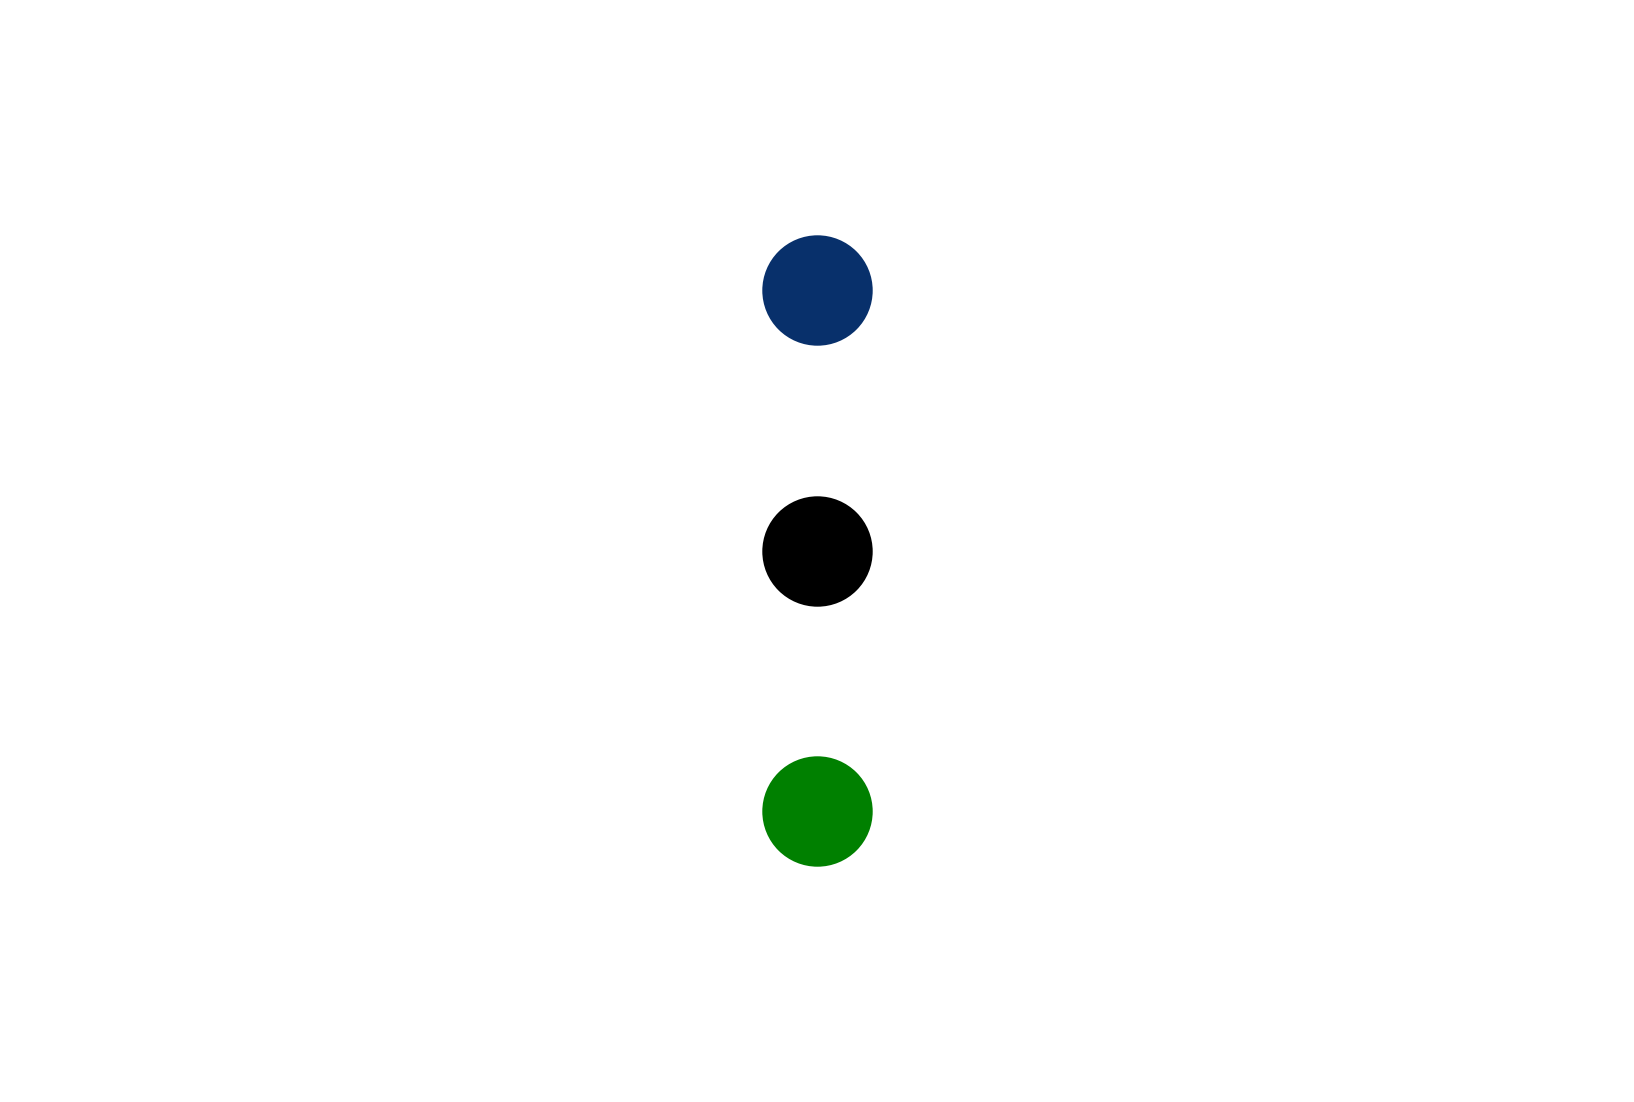

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x=0, y=0, s=600, color='green',marker=".")
ax.scatter(x=0, y=100, s=600, color='black',marker=".")
ax.scatter(x=0, y=200, s=600, color='#08306b',marker=".")
ax.set_ylim(-100,300)
ax.axis('off')
fig.savefig(_FIGURE_DIR/"Fig2_C_Legend")